In [1]:
import sympy as sym
import numpy as np
from sympy import lambdify
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
import pandas as pd
import torch
import torch.nn as nn
import joblib
import time
import pickle
import warnings

In [2]:
warnings.filterwarnings("ignore", message="X does not have valid feature names*")


# Define functions, tensors, grid

In [3]:
# Define symbols
x1, x2 = sym.Symbol('x1'), sym.Symbol('x2')  # Spatial variables
mu = sym.Symbol('mu')
alpha = sym.Symbol('alpha')
a, b = sym.Symbol('a'), sym.Symbol('b')  # Deformation parameters

## Defromation

In [4]:
# Deformation functions
u1 = a * x1 * x1 * x2
u2 = b * x2 * x1
lam_u1 = lambdify([x1,x2,a], u1, "numpy")
lam_u2 = lambdify([x1,x2,b], u2, "numpy")

In [5]:
# Deformation gradient and strain tensors
uGrad=sym.Matrix([
                [sym.diff(u1, x1, 1), sym.diff(u1, x2, 1)],
                [sym.diff(u2, x1, 1), sym.diff(u2, x2, 1)]]
                )
uEps=(uGrad + uGrad.transpose()) / 2
uEpsTrace=sym.Trace(uEps).simplify()

## A tensors

In [6]:
# Stress Tensors for yields
A1 = 2 * mu * uEps + alpha * uEpsTrace * sym.eye(2)  # first yield
A2 = 2 * mu * uEps + alpha * uEpsTrace * sym.eye(2)  # second yield

In [7]:
# Lambdify to create functions
lam_A1 = sym.lambdify([x1, x2, mu, alpha, a, b], A1, "numpy")  # Function for A1
lam_A2 = sym.lambdify([x1, x2, mu, alpha, a, b], A2, "numpy")  # Function for A2

## P tensors

In [8]:
SMALL_EPS = 1e-12  # small epsilon to avoid dividing by zero

In [9]:
def compute_next_P2(dev_A2, mu, P1, sigma_y2, h2):
    """
    Computes the next iteration for P2 based on the current state of P1.

    Args:
        dev_A2 (np.array): Deviatoric stress tensor A2.
        mu (float): Shear modulus.
        P1 (np.array): Current estimate of P1.
        sigma_y2 (float): Yield stress for second mechanism.
        h2 (float): Hardening parameter for second mechanism.

    Returns:
        next_P2 (np.array): Updated P2.
    """
    norm_val = np.linalg.norm(dev_A2 - 2 * mu * P1, 'fro')
    max_val = max(0, norm_val - sigma_y2)
    next_P2 = (max_val / (2 * mu + h2)) * (dev_A2 - 2 * mu * P1) / (norm_val + SMALL_EPS)
    return next_P2

In [10]:
def compute_next_P1(dev_A1, mu, P2, sigma_y1, h1):
    """
    Computes the next iteration for P1 based on the current state of P2.

    Args:
        dev_A1 (np.array): Deviatoric stress tensor A1.
        mu (float): Shear modulus.
        P2 (np.array): Current estimate of P2.
        sigma_y1 (float): Yield stress for first mechanism.
        h1 (float): Hardening parameter for first mechanism.

    Returns:
        next_P1 (np.array): Updated P1.
    """
    norm_val = np.linalg.norm(dev_A1 - 2 * mu * P2, 'fro')
    max_val = max(0, norm_val - sigma_y1)
    next_P1 = (max_val / (2 * mu + h1)) * (dev_A1 - 2 * mu * P2) / (norm_val + SMALL_EPS)
    return next_P1

In [11]:
def check_tolerance(P1, next_P1, P2, next_P2, tolerance):
    """
    Checks convergence based on relative change in P1 and P2.

    Args:
        P1 (np.array): Current P1.
        next_P1 (np.array): Updated P1.
        P2 (np.array): Current P2.
        next_P2 (np.array): Updated P2.
        tolerance (float): Convergence threshold.

    Returns:
        bool: True if iteration should continue, False if convergence reached.
    """
    numerator = np.linalg.norm(next_P1 - P1, 'fro') + np.linalg.norm(next_P2 - P2, 'fro')
    denominator = np.linalg.norm(next_P1, 'fro') + np.linalg.norm(next_P2, 'fro') + np.linalg.norm(P1, 'fro') + np.linalg.norm(P2, 'fro')

    return (numerator / (denominator + SMALL_EPS)) > tolerance


In [12]:
def compute_initial_P1_P2(A1, A2, mu, h1, h2, sigma_y1, sigma_y2):
    """
    Computes the initial estimates for P1 and P2 using the given A1 and A2.

    Args:
        A1 (np.array): Stress tensor A1.
        A2 (np.array): Stress tensor A2.
        mu (float): Shear modulus (same for both plasticity mechanisms).
        h1 (float): Hardening parameter for the first yield mechanism.
        h2 (float): Hardening parameter for the second yield mechanism.
        sigma_y1 (float): Yield stress for the first mechanism.
        sigma_y2 (float): Yield stress for the second mechanism.

    Returns:
        P1_init (np.array): Initial estimate for P1.
        P2_init (np.array): Initial estimate for P2.
    """
    # Compute deviatoric parts
    dev_A1 = A1 - (np.trace(A1) / 2) * np.eye(2)
    dev_A2 = A2 - (np.trace(A2) / 2) * np.eye(2)

    # Compute norm
    norm_dev_A2 = np.linalg.norm(dev_A2, 'fro')

    # Compute initial P2
    P2_init = (max(0, norm_dev_A2 - sigma_y2) / (2 * mu + h2)) * (dev_A2 / (norm_dev_A2 + SMALL_EPS))  # Avoid division by zero

    # Compute initial P1
    norm_dev_A1_P2 = np.linalg.norm(dev_A1 - 2 * mu * P2_init, 'fro')
    P1_init = (max(0, norm_dev_A1_P2 - sigma_y1) / (2 * mu + h1)) * ((dev_A1 - 2 * mu * P2_init) / (norm_dev_A1_P2 + SMALL_EPS))

    return P1_init, P2_init

In [13]:
def compute_P1_P2_iter(A1, A2, P1_init, P2_init, mu, h1, h2, sigma_y1, sigma_y2, tol=1e-12, max_iter=100):
    """
    Iteratively computes P1 and P2 using the alternating direction minimization method. This algorithm is taken from

    Args:
        A1 (np.array): Stress tensor A1.
        A2 (np.array): Stress tensor A2.
        P1_init (np.array): Initial guess for P1.
        P2_init (np.array): Initial guess for P2.
        mu (float): Shear modulus (same for both plasticity mechanisms).
        h1 (float): Hardening parameter for the first yield mechanism.
        h2 (float): Hardening parameter for the second yield mechanism.
        sigma_y1 (float): Yield stress for the first mechanism.
        sigma_y2 (float): Yield stress for the second mechanism.
        tol (float, optional): Convergence tolerance. Default is 1e-12.
        max_iter (int, optional): Maximum number of iterations. Default is 100.

    Returns:
        P1 (np.array): Final solution for P1.
        P2 (np.array): Final solution for P2.
        num_iter (int): Number of iterations taken.
        iter_history (list of tuples): History of (P1[0, 0], P1[0, 1], P2[0, 0], P2[0, 1]) at each iteration.
    """
    A1 = np.array(A1, dtype=float)
    A2 = np.array(A2, dtype=float)
    #dev_A1 = lam_dev_A1_from_A(A1)
    dev_A1 = A1 - (A1.trace() / 2) * np.eye(2)
    #dev_A2 = lam_dev_A2_from_A(A2)
    dev_A2 = A2 - (A2.trace() / 2) * np.eye(2)

    # Step (a) - Initial approximation
    P1, P2 = np.array(P1_init, dtype=float), np.array(P2_init, dtype=float)
    iter_history = [(P1[0, 0], P1[0, 1], P2[0, 0], P2[0, 1])]

    for i in range(max_iter):
        # print(f"Current iteration is {i}")
        # Step (b) - Update P2
        next_P2 = compute_next_P2(dev_A2, mu, P1, sigma_y2, h2)  # analytic 6.56 is used

        # Store iteration values
        iter_history.append((P1[0, 0], P1[0, 1], next_P2[0, 0], next_P2[0, 1]))

        # Step (c) - Update P1
        next_P1 = compute_next_P1(dev_A1, mu, next_P2, sigma_y1, h1)  # analytic 6.57 is used

        # Store iteration values
        iter_history.append((next_P1[0, 0], next_P1[0, 1], next_P2[0, 0], next_P2[0, 1]))

        # Step (d) - Check convergence
        if not check_tolerance(P1, next_P1, P2, next_P2, tol):
            return P1, P2, i + 1, iter_history

        # Update P1 and P2
        P1 = next_P1
        P2 = next_P2

    return P1, P2, max_iter, iter_history

### Check on example from dissertation

In [14]:
# example 6.2 from dissertation
A1 = A2 = np.array([[20, 0], [0, 0]])
dev_A1 = A1 - (A1.trace() / 2) * np.eye(2)
dev_A2 = A2 - (A2.trace() / 2) * np.eye(2)

In [15]:
P1_init, P2_init = compute_initial_P1_P2(A1, A2, 1, 1, 1, 1, 2)

In [16]:
# Print results
print("P2_init:\n", P2_init)
print("P1_init:\n", P1_init)

P2_init:
 [[ 2.86192881  0.        ]
 [ 0.         -2.86192881]]
P1_init:
 [[ 1.18967853  0.        ]
 [ 0.         -1.18967853]]


In [17]:
P1, P2, num_iter, iter_history = compute_P1_P2_iter(A1, A2, P1_init, P2_init, 1, 1, 1, 1, 2)

In [18]:
print(P1)
print(P2)
print(num_iter)

[[ 2.14142136  0.        ]
 [ 0.         -2.14142136]]
[[ 1.43431458  0.        ]
 [ 0.         -1.43431458]]
33


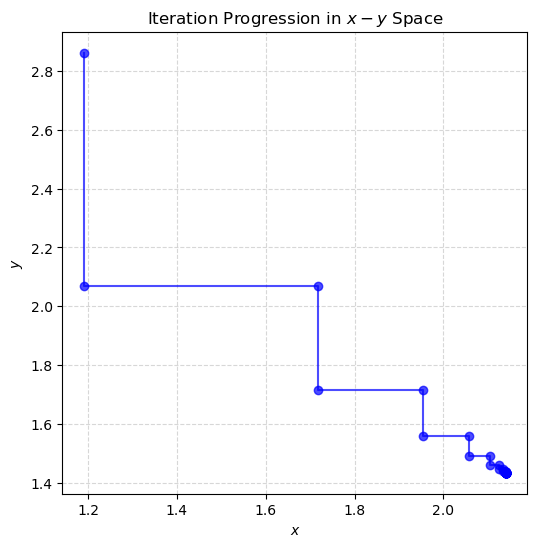

In [19]:
# Extract x and y values from the iteration history
x_values = [p1 for p1, p2, p3, p4 in iter_history]
y_values = [p3 for p1, p2, p3, p4 in iter_history]
#
# # Create the plot
plt.figure(figsize=(6,6))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', markersize=6, alpha=0.7)
#
# Labels and title
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Iteration Progression in $x-y$ Space')
#plt.savefig('../images/multi-yield/example_6.2.png', format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
# Show the grid and plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

The implementation follows Example 6.2 from:
- Jan Valdman, "Mathematical and Numerical Analysis of Elastoplastic Material with Multi-Surface Stress-Strain Relation", Technische Fakultät, Christian-Albrechts-Universität zu Kiel, 2001, pp. 62-63.

The obtained results match the dissertation, confirming correctness.

## Grid, Calculate A, P norms


In [14]:
# Grid definition
x1_min = 0
x1_max = 2
x2_min = 0
x2_max = 1
N1 = 900
N2 = x2_max * N1 // x1_max

In [15]:
print(N1*N2)

405000


In [16]:
x1_grid = np.linspace(x1_min, x1_max, N1, endpoint=True)
x2_grid = np.linspace(x2_min, x2_max, N2, endpoint=True)
X1 = np.tile(x1_grid.reshape(1, N1), (N2, 1))
X2 = np.tile(x2_grid.reshape(N2, 1), (1, N1))

In [22]:
# Deformation parameters
mu1_val = mu2_val = 80e9
alpha1_val = alpha2_val = 121e9
sigma_y1_val = 400e8
sigma_y2_val = 410e8
h1_val = 50
h2_val = 55
a_val = 0.5
b_val = 0.25

In [18]:
# Evaluate displacement functions
U1 = lam_u1(X1, X2, a_val)
U2 = lam_u2(X1, X2, b_val)

In [19]:
# Initialize storage for norms
norms_A1_grid = np.zeros_like(X1)  # Norm of A1
norms_A2_grid = np.zeros_like(X1)  # Norm of A2
norms_P1_grid = np.zeros_like(X1)  # Norm of P1
norms_P2_grid = np.zeros_like(X1)  # Norm of P2
indicator_norm_P1 = np.zeros_like(X1)  # 1 if P1 > 0
indicator_norm_P2 = np.zeros_like(X1)  # 1 if P2 > 0
norm_dev_A1_grid = np.zeros_like(X1)  # Deviator norm of A1
norm_dev_A2_grid = np.zeros_like(X1)  # Deviator norm of A2

# Iterate through the grid
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x1_val = X1[i, j]
        x2_val = X2[i, j]

        # Compute A1, A2, P1, P2 for current point
        A1 = lam_A1(x1_val, x2_val, mu1_val, alpha1_val, a_val, b_val)
        A2 = lam_A2(x1_val, x2_val, mu2_val, alpha2_val, a_val, b_val)
        P1_init, P2_init = compute_initial_P1_P2(A1, A2, mu1_val, h1_val, h2_val, sigma_y1_val, sigma_y2_val)
        P1, P2, _, _ = compute_P1_P2_iter(A1, A2, P1_init, P2_init, mu1_val, h1_val, h2_val, sigma_y1_val, sigma_y2_val, tol=1e-12)

        # Compute Frobenius norms
        norms_A1_grid[i, j] = np.linalg.norm(A1, ord='fro')
        norms_A2_grid[i, j] = np.linalg.norm(A2, ord='fro')
        norms_P1_grid[i, j] = np.linalg.norm(P1, ord='fro')
        norms_P2_grid[i, j] = np.linalg.norm(P2, ord='fro')

        # Compute deviatoric parts
        dev_A1 = A1 - (np.trace(A1) / 2) * np.eye(2)
        dev_A2 = A2 - (np.trace(A2) / 2) * np.eye(2)
        norm_dev_A1_grid[i, j] = np.linalg.norm(dev_A1, ord='fro')
        norm_dev_A2_grid[i, j] = np.linalg.norm(dev_A2, ord='fro')

        # Set plasticity indicators
        indicator_norm_P1[i, j] = 1 if norms_P1_grid[i, j] > 0 else 0
        indicator_norm_P2[i, j] = 1 if norms_P2_grid[i, j] > 0 else 0

# Visualisations

## Non-deformed grid

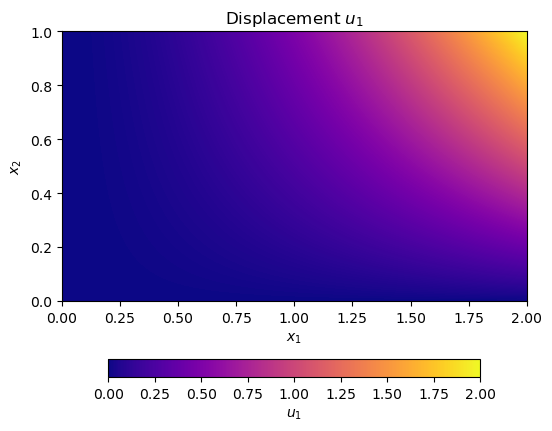

In [26]:
# Plot the results
plt.figure(figsize=(6, 5))
plt.title("Displacement $u_1$")
plt.imshow(U1, extent=(x1_min, x1_max, x2_min, x2_max), origin='lower', aspect='auto', cmap='plasma')

# Add a horizontal colorbar at the bottom
cbar = plt.colorbar(label="$u_1$", orientation='horizontal', pad=0.15, shrink = 0.8)  # `pad` regulates distance to graph

# Add labels and save
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
#plt.savefig('../images/multi-yield/Displacement_U1.png', format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
plt.show()

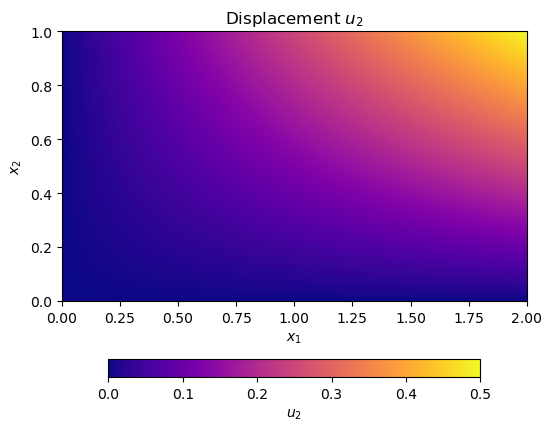

In [27]:
plt.figure(figsize=(6, 5))
plt.title("Displacement $u_2$")
plt.imshow(U2, extent=(x1_min, x1_max, x2_min, x2_max), origin='lower', aspect='auto', cmap='plasma')
# Add a horizontal colorbar at the bottom
cbar = plt.colorbar(label="$u_2$", orientation='horizontal', pad=0.15, shrink = 0.8)  # `pad` regulates distance to graph

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
#plt.savefig('../images/multi-yield/Displacement_U2.png', format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
plt.show()

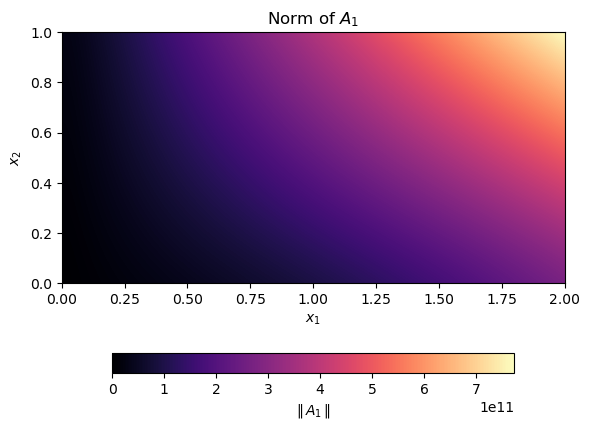

In [28]:
# Plot norm of A1
plt.figure(figsize=(6, 5))
plt.title("Norm of $A_1$")
plt.imshow(norms_A1_grid, extent=(x1_min, x1_max, x2_min, x2_max), origin='lower', cmap='magma')
cbar = plt.colorbar(label=r"$\|\,A_1\,\|$", orientation='horizontal', pad=0.15, shrink = 0.8)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
#plt.savefig("../images/multi-yield/norm_A1.png", format='png', dpi = 300, bbox_inches = 'tight')  # uncomment/comment to save/not to save
plt.show()

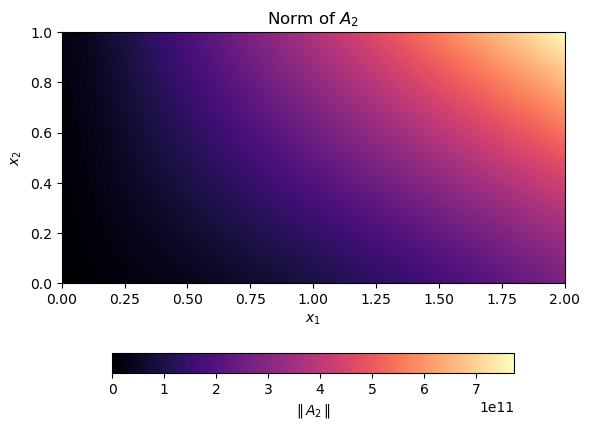

In [29]:
# Plot norm of A2
plt.figure(figsize=(6, 5))
plt.title("Norm of $A_2$")
plt.imshow(norms_A2_grid, extent=(x1_min, x1_max, x2_min, x2_max), origin='lower', cmap='magma')
cbar = plt.colorbar(label=r"$\|\,A_2\,\|$", orientation='horizontal', pad=0.15, shrink = 0.8)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
#plt.savefig("../images/multi-yield/norm_A2.png", format='png', dpi = 300, bbox_inches = 'tight')  # uncomment/comment to save/not to save
plt.show()

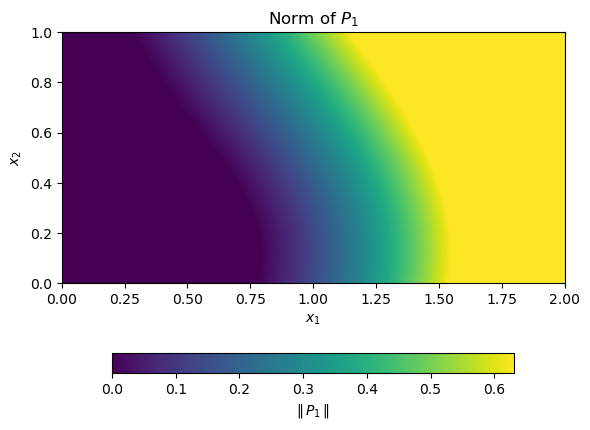

In [30]:
# Plot norm of P1
plt.figure(figsize=(6, 5))
plt.title("Norm of $P_1$")
plt.imshow(norms_P1_grid, extent=(x1_min, x1_max, x2_min, x2_max), origin='lower', cmap='viridis')
cbar = plt.colorbar(label=r"$\|\,P_1\,\|$", orientation='horizontal', pad=0.15, shrink = 0.8)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
#plt.savefig("../images/multi-yield/norm_P1.png", format='png', dpi = 300, bbox_inches = 'tight')  # uncomment/comment to save/not to save
plt.show()

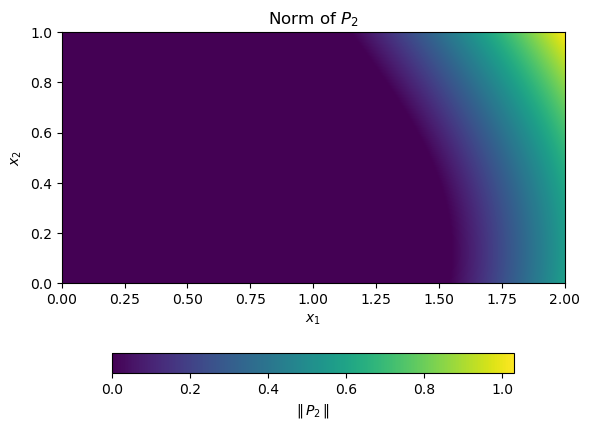

In [31]:
# Plot norm of P2
plt.figure(figsize=(6, 5))
plt.title("Norm of $P_2$")
plt.imshow(norms_P2_grid, extent=(x1_min, x1_max, x2_min, x2_max), origin='lower', cmap='viridis')
cbar = plt.colorbar(label=r"$\|\,P_2\,\|$", orientation='horizontal', pad=0.15, shrink=0.8)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
#plt.savefig("../images/multi-yield/norm_P2.png", format='png', dpi = 300, bbox_inches = 'tight')  # uncomment/comment to save/not to save
plt.show()

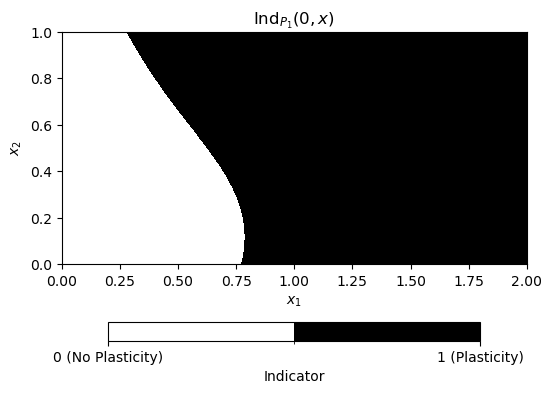

In [32]:
# Plot indicator norm of P1
# Create a discrete colormap: white for 0, black for 1
cmap = mcolors.ListedColormap(["white", "black"])
bounds = [0, 0.5, 1]  # Boundary values to separate 0 and 1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6, 5))
plt.title(r"$\mathrm{Ind}_{P_1}(0, x)$")

# IMPORTANT: save the result of imshow to 'im1'
im1 = plt.imshow(
    indicator_norm_P1,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)

# Axis labels
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

cbar = plt.colorbar(im1, orientation='horizontal', pad=0.15, ticks=[0, 1], shrink=0.8)
cbar.ax.set_xticklabels(["0 (No Plasticity)", "1 (Plasticity)"])
cbar.set_label("Indicator")


# Save and show
#plt.savefig("../images/multi-yield/indicator_norm_P1.png", format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
plt.show()

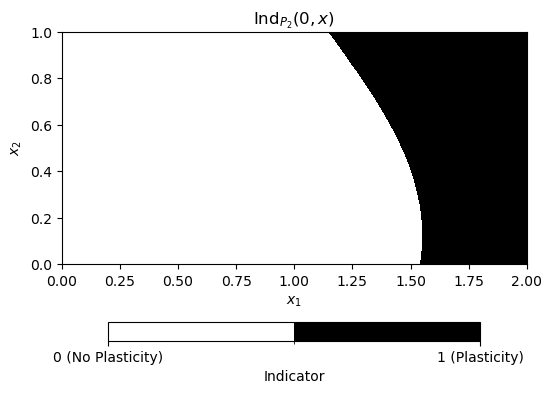

In [33]:
# Plot indicator norm of P2
# Create a discrete colormap: white for 0, black for 1
cmap = mcolors.ListedColormap(["white", "black"])
bounds = [0, 0.5, 1]  # Boundary values to separate 0 and 1
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6, 5))
plt.title(r"$\mathrm{Ind}_{P_2}(0, x)$")

# IMPORTANT: save the result of imshow to 'im1'
im1 = plt.imshow(
    indicator_norm_P2,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)

# Axis labels
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

cbar = plt.colorbar(im1, orientation='horizontal', pad=0.15, ticks=[0, 1], shrink=0.8)
cbar.ax.set_xticklabels(["0 (No Plasticity)", "1 (Plasticity)"])
cbar.set_label("Indicator")


# Save and show
#plt.savefig("../images/multi-yield/indicator_norm_P2.png", format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
plt.show()

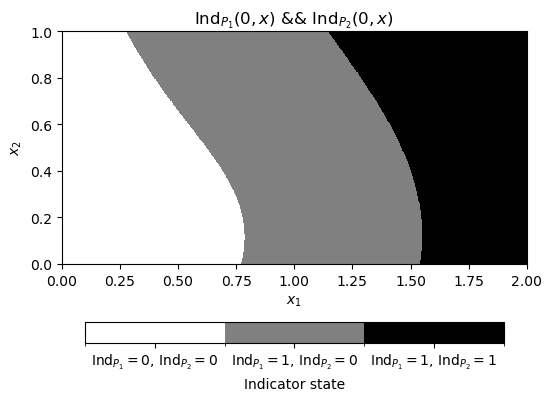

In [34]:
# Create an indicator matrix for three states:
# 0 – Both norms P1 and P2 are zero (No Plasticity)
# 1 – P1 is nonzero, P2 is zero (First Threshold Exceeded)
# 2 – Both P1 and P2 are nonzero (Second Threshold Exceeded)
indicator = np.zeros_like(indicator_norm_P1)
indicator[(indicator_norm_P1 > 0) & (indicator_norm_P2 == 0)] = 1  # First threshold exceeded
indicator[(indicator_norm_P1 > 0) & (indicator_norm_P2 > 0)] = 2  # Second threshold exceeded

# Define a discrete colormap with three colors:
# White (0) – No Plasticity
# Gray (1) – First threshold exceeded
# Black (2) – Second threshold exceeded
cmap = mcolors.ListedColormap(["white", "gray", "black"])
bounds = [0, 1, 2, 3]  # Boundaries for each zone
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the plot
plt.figure(figsize=(6, 5))
plt.title(r"$\mathrm{Ind}_{P_1}(0,x)$ && $\mathrm{Ind}_{P_2}(0,x)$")

# Plot the indicator matrix with the defined colormap
im = plt.imshow(
    indicator,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm,
    interpolation='nearest',
)

# Set axis labels
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# Add a colorbar below the plot
cbar = plt.colorbar(im,
                    orientation='horizontal',
                    pad=0.15,
                    ticks=[0.5,1.5,2.5],
                    shrink=0.9)

# Customize colorbar labels to match plasticity states
cbar.set_ticklabels([
    "Ind$_{P_1}=0$, Ind$_{P_2}=0$",
    "Ind$_{P_1}=1$, Ind$_{P_2}=0$",
    "Ind$_{P_1}=1$, Ind$_{P_2}=1$",
])
cbar.set_label("Indicator state")

# Save the figure (uncomment if needed)
#plt.savefig("../images/multi-yield/plasticity_regions.png", format="png", dpi = 300, bbox_inches="tight")

# Display the plot
plt.show()

## Deformed grid

In [20]:
ampl = 1
Y1 = X1 + ampl * U1
Y2 = X2 + ampl * U2

In [21]:
# Flatten the grid
points_x = Y1.flatten()
points_y = Y2.flatten()

In [22]:
# Create triangulation
triangles = tri.Triangulation(points_x, points_y)

In [23]:
p1_flat = norms_P1_grid.flatten()
p2_flat = norms_P2_grid.flatten()
ind1_flat = indicator_norm_P1.flatten()
ind2_flat = indicator_norm_P2.flatten()

In [24]:
p1_tri = p1_flat[triangles.triangles].mean(axis=1)
p2_tri = p2_flat[triangles.triangles].mean(axis=1)
ind1_tri = (ind1_flat[triangles.triangles].sum(axis=1) > 0).astype(int)
ind2_tri = (ind2_flat[triangles.triangles].sum(axis=1) > 0).astype(int)

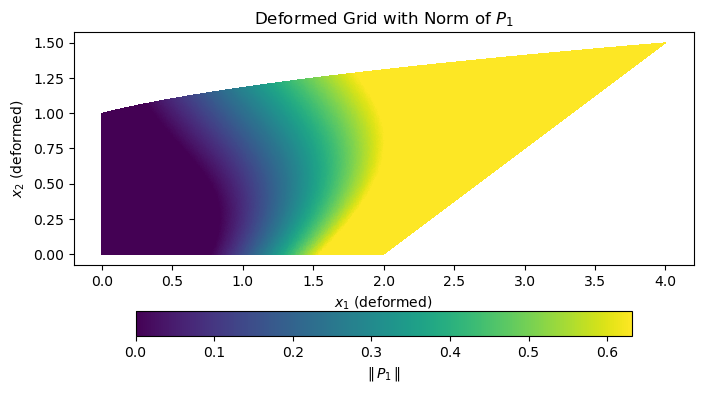

In [25]:
# Plotting with color mapping
plt.figure(figsize=(8, 6))
plt.tripcolor(triangles, facecolors=p1_tri, cmap='viridis')
plt.triplot(triangles, color='black', alpha=0, linewidth=0)
cbar = plt.colorbar(label=r"$\|\,P_1\,\|$", orientation='horizontal', pad=0.1, shrink=0.8)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Deformed Grid with Norm of $P_1$")
plt.xlabel("$x_1$ (deformed)")
plt.ylabel("$x_2$ (deformed)")
plt.savefig('../images/multi-yield/Deformation_Grid_Visualization_with_Norms_of_P1.png', format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
plt.show()

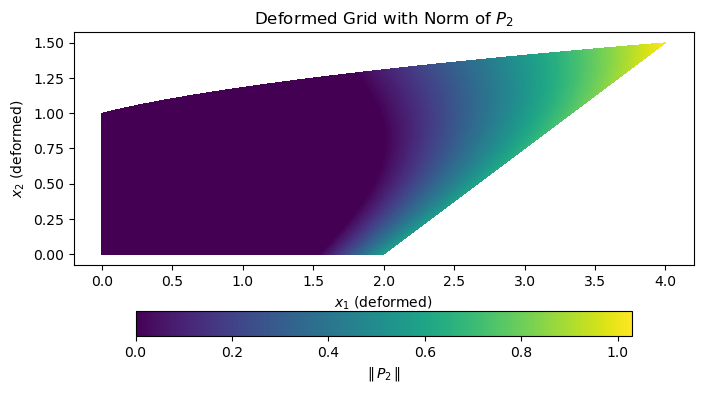

In [26]:
# Plotting with color mapping
plt.figure(figsize=(8, 6))
plt.tripcolor(triangles, facecolors=p2_tri, cmap='viridis')
plt.triplot(triangles, color='black', alpha=0, linewidth=0)
cbar = plt.colorbar(label=r"$\|\,P_2\,\|$", orientation='horizontal', pad=0.1, shrink=0.8)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Deformed Grid with Norm of $P_2$")
plt.xlabel("$x_1$ (deformed)")
plt.ylabel("$x_2$ (deformed)")
plt.savefig('../images/multi-yield/Deformation_Grid_Visualization_with_Norms_of_P2.png', format='png', dpi = 300, bbox_inches='tight')  # uncomment/comment to save/not to save
plt.show()

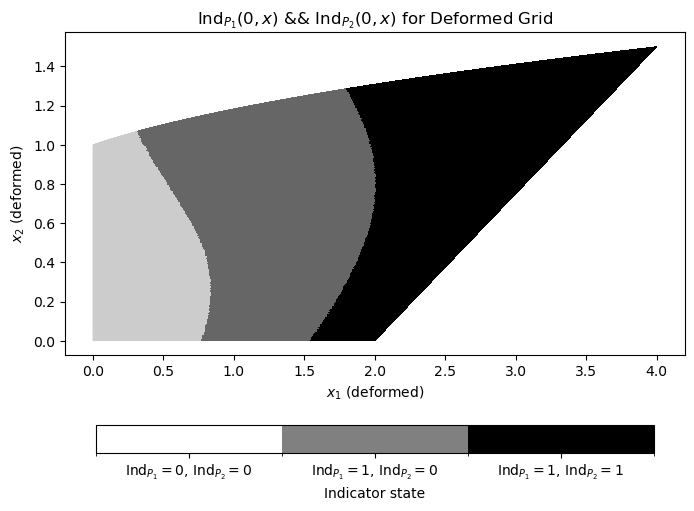

In [42]:
# Create indicator values for three plasticity states
indicator = np.zeros_like(p1_tri, dtype=int)
indicator[(p1_tri > 0) & (p2_tri == 0)] = 1  # First threshold exceeded
indicator[(p1_tri > 0) &  (p2_tri > 0)] = 2  # Second threshold exceeded

# Define a discrete colormap with three colors:
cmap = mcolors.ListedColormap(["white", "gray", "black"])  # No plasticity, first threshold, second threshold
bounds = [0, 1, 2, 3]  # Boundaries for each zone
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create the plot
plt.figure(figsize=(8, 6))
plt.title(r"$\mathrm{Ind}_{P_1}(0,x)$ && $\mathrm{Ind}_{P_2}(0,x)$ for Deformed Grid")

# Plot the indicator matrix with the defined colormap
im = plt.tripcolor(triangles, indicator, cmap=cmap, norm=norm)

# Add grid lines (triangle edges)
plt.triplot(triangles, color="black", linewidth=0.2, alpha=0.2)

# Set axis labels
plt.xlabel("$x_1$ (deformed)")
plt.ylabel("$x_2$ (deformed)")

# Add a colorbar below the plot
cbar = plt.colorbar(im,
                    orientation='horizontal',
                    pad=0.15,
                    ticks=[0.5,1.5,2.5],
                    shrink=0.9)

# Customize colorbar labels to match plasticity states
cbar.set_ticklabels([
    "Ind$_{P_1}=0$, Ind$_{P_2}=0$",
    "Ind$_{P_1}=1$, Ind$_{P_2}=0$",
    "Ind$_{P_1}=1$, Ind$_{P_2}=1$",
])
cbar.set_label("Indicator state")

# Save the figure (uncomment/comment if needed)
#plt.savefig("../images/multi-yield/plasticity_indicator_deformed_with_grid.png", format="png", dpi = 300, bbox_inches="tight")

# Display the plot
plt.show()

# Create data for training

In [43]:
# Initialize lists to store training data
data = []

In [44]:
print(X1.shape[0])

450


In [45]:
print(X1.shape[1])

900


In [46]:
# Iterate through the grid to collect data without deformation
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x1_val = X1[i, j]
        x2_val = X2[i, j]

        # Compute A1 and A2 (assuming they are identical for training)
        A = lam_A1(x1_val, x2_val, mu1_val, alpha1_val, a_val, b_val)

        # Compute initial P1, P2
        P1_init, P2_init = compute_initial_P1_P2(A, A, mu1_val, h1_val, h2_val, sigma_y1_val, sigma_y2_val)

        # Compute final P1, P2
        P1, P2, _, _ = compute_P1_P2_iter(A, A, P1_init, P2_init, mu1_val, h1_val, h2_val, sigma_y1_val, sigma_y2_val, tol=1e-12)

        #
        A_vector = A.flatten().tolist() # 4 values
        P1_init_vector = P1_init.flatten().tolist()
        P2_init_vector = P2_init.flatten().tolist()
        P1_vector = P1.flatten().tolist()
        P2_vector = P2.flatten().tolist()


        # Append to dataset
        data.append(A_vector + P1_init_vector + P2_init_vector + P1_vector + P2_vector)

In [47]:
# Convert to DataFrame and save
df = pd.DataFrame(data, columns=[
    "$A_{00}$", "$A_{01}$", "$A_{10}$", "$A_{11}$",
    "$P_{1}^{0}{}_{00}$", "$P_{1}^{0}{}_{01}$", "$P_{1}^{0}{}_{10}$", "$P_{1}^{0}{}_{11}$",
    "$P_{2}^{0}{}_{00}$", "$P_{2}^{0}{}_{01}$", "$P_{2}^{0}{}_{10}$", "$P_{2}^{0}{}_{11}$",
    r"$P_{1\,00}$", r"$P_{1\,01}$", r"$P_{1\,10}$", r"$P_{1\,11}$",
    r"$P_{2\,00}$", r"$P_{2\,01}$", r"$P_{2\,10}$", r"$P_{2\,11}$"
])
# Save to CSV
csv_filename = "../data/multi-yield_training_data.csv"
df.to_csv(csv_filename, index=False)

In [48]:
print(df.shape)

(405000, 20)


# Using Neural Network

In [14]:
class DynamicMLP(nn.Module):
    """
    Multilayer perceptron (MLP) with dynamic layer configuration and optional Dropout regularisation.

    This class allows the creation of MLPs with an arbitrary number of layers and neurons, and with the ability to
    adding Dropout between layers to prevent overfitting.

    Args:
        layers (list): A list containing the number of neurons in each layer. The length of the list determines
                       the number of layers; the list values are the number of neurons in each corresponding layer.
        dropout_rate (float, optional): The probability of neurons in Dropout layers being switched off.
                                        The default is 0, which means no Dropout.
    """
    def __init__(self, layers, dropout_rate=0):
        super(DynamicMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout_rate = dropout_rate

        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:  # no activation function after last layer
                self.layers.append(nn.ReLU())  # Reduced linear unit
                if self.dropout_rate != 0:
                    self.layers.append(nn.Dropout(self.dropout_rate))

    def forward(self, x):
        """
        Forward pass of the MLP model.

        This method propagates the input `x` through the network layers, applying
        linear transformations, ReLU activations (except for the last layer), and
        optional dropout regularization.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, output_dim).
        """
        x = x.flatten(start_dim=1)
        for layer in self.layers:
            x = layer(x)
        return x

In [15]:
with open("multi-yield_best_model.pkl", "rb") as f:
    saved_data = pickle.load(f)
model_state = saved_data["model_state"]
best_config = saved_data["config"]

model = DynamicMLP(best_config["layers"], dropout_rate=best_config["dropout"])
model.load_state_dict(model_state)

print("Loaded configuration:", best_config)

Loaded configuration: {'layers': [7, 512, 256, 128, 4], 'dropout': 0, 'optimizer': 'adam', 'lr': 0.001, 'weight_decay': 0.0001, 'delta': 0.5, 'val_loss': 7.969989274084655e-05}


In [16]:
def process_in_batches(data, model, batch_size=10000, device=None):
    """
    Processes large input data in batches through the neural network.

    This function efficiently processes large datasets by splitting them into smaller
    batches and passing them through the given neural network model. It automatically
    detects and utilizes the available computing device (CPU/GPU) to optimize performance.

    Args:
        data (numpy.ndarray): A 2D array of input features, where each row is a sample.
        model (torch.nn.Module): A trained PyTorch neural network model.
        batch_size (int, optional): The number of samples processed in a single batch
                                    (default: 10000). Larger batch sizes may improve
                                    performance but require more memory.
        device (str or torch.device, optional): a computing device, e.g. "cpu" or "cuda".
                                                By default, it is automatically selected.

    Returns:
        numpy.ndarray: A 2D array of model predictions, with the same number of rows as `data`.
                       The predictions are computed in batches and concatenated to form
                       the final output.

    Notes:
        - The function automatically transfers the model and input data to the available
          computing device (GPU if available, otherwise CPU).
        - The model is set to evaluation mode (`model.eval()`) to ensure that dropout and
          batch normalization layers (if present) behave consistently.
        - Computation is performed without tracking gradients (`torch.no_grad()`)
          to reduce memory usage and improve inference speed.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)
    model.to(device)  # Move model to the appropriate device
    model.eval()  # Set model to evaluation mode

    num_samples = data.shape[0]
    results = []

    for i in range(0, num_samples, batch_size):
        batch = torch.tensor(data[i:i + batch_size], dtype=torch.float32).to(device)  # Move batch to device
        with torch.no_grad():
            batch_result = model(batch).cpu().numpy()  # Compute predictions and move back to CPU
        results.append(batch_result)

    return np.vstack(results)  # Concatenate all batch results into a single output array


In [17]:
# Load scaler
A_scaler = joblib.load('multi-yield_scaler_A.pkl')
P_init_scaler = joblib.load('multi-yield_scaler_P_init.pkl')
P_target_scaler = joblib.load('multi-yield_scaler_P_target.pkl')

## Test grid comparisom

In [18]:
# bigger grid definition
x1_min = 0
x1_max = 2
x2_min = 0
x2_max = 1
N1 = 1800
N2 = x2_max * N1 // x1_max

In [19]:
x1_grid = np.linspace(x1_min, x1_max, N1, endpoint=True)
x2_grid = np.linspace(x2_min, x2_max, N2, endpoint=True)
X1 = np.tile(x1_grid.reshape(1, N1), (N2, 1))
X2 = np.tile(x2_grid.reshape(N2, 1), (1, N1))

In [20]:
# Flatten X1 and X2 to prepare for batch computation
x1_vals = X1.flatten()
x2_vals = X2.flatten()

In [23]:
# Evaluate displacement functions
U1 = lam_u1(X1, X2, a_val)
U2 = lam_u2(X1, X2, b_val)

In [24]:
# -------------------------
# Method 1: Analytic
# -------------------------

# Measure time for iterative-based computation
start_analytic = time.time()

# Initialize storage for P1 and P2
P1_analytic = []
P2_analytic = []

# Compute P1 and P2 for all points in the grid
for x1, x2 in zip(x1_vals, x2_vals):
    A1 = lam_A1(x1, x2, mu1_val, alpha1_val, a_val, b_val)
    A2 = lam_A2(x1, x2, mu2_val, alpha2_val, a_val, b_val)

    P1_init, P2_init = compute_initial_P1_P2(A1, A2, mu1_val, h1_val, h2_val, sigma_y1_val, sigma_y2_val)
    P1, P2, _, _ = compute_P1_P2_iter(A1, A2, P1_init, P2_init, mu1_val, h1_val, h2_val, sigma_y1_val, sigma_y2_val, tol=1e-12)

    P1_analytic.append(P1)
    P2_analytic.append(P2)

time_analytic = time.time() - start_analytic

# Convert lists to numpy arrays and reshape
P1_analytic = np.array(P1_analytic)
P2_analytic = np.array(P2_analytic)

# Compute norms and indicators for analytic-based results
norms_P1_grid = np.linalg.norm(P1_analytic, ord='fro', axis=(1, 2)).reshape(X1.shape)
norms_P2_grid = np.linalg.norm(P2_analytic, ord='fro', axis=(1, 2)).reshape(X1.shape)

indicator_norm_P1 = (norms_P1_grid > 0).astype(int)
indicator_norm_P2 = (norms_P2_grid > 0).astype(int)

In [25]:
print(f"Analytic Time: {time_analytic:.2f} seconds")

Analytic Time: 2193.54 seconds


In [26]:
# -------------------------
# Method 2: Using Neural Network
# -------------------------

BATCH_SIZE = 10000  # Adjust based on available memory

# Measure time for NN-based computation
start_nn = time.time()

# Prepare input matrices
input_vectors = []

for x1, x2 in zip(x1_vals, x2_vals):
    # 1. Compute A and initial values
    A = lam_A1(x1, x2, mu1_val, alpha1_val, a_val, b_val)
    P1_init, P2_init = compute_initial_P1_P2(A, A, mu1_val, h1_val, h2_val, sigma_y1_val, sigma_y2_val)

    # 2. Transform A (log1p and keep symmetric components only)
    log_A = np.log1p(A)
    A_vector = np.array([log_A[0, 0], log_A[0, 1], log_A[1, 1]])
    A_scaled = A_scaler.transform(A_vector.reshape(1, -1)).flatten()

    # 3. Transform P_init values (diagonal and off-diagonal from both)
    P_init_vector = np.array([P1_init[0, 0], P1_init[0, 1], P2_init[0, 0], P2_init[0, 1]])
    P_init_scaled = P_init_scaler.transform(P_init_vector.reshape(1, -1)).flatten()

    # 4. Concatenate input vector
    input_vector = np.concatenate([A_scaled, P_init_scaled])
    input_vectors.append(input_vector)

# Convert all inputs to numpy array
input_scaled = np.array(input_vectors)

# 5. Feed into neural network
P1_P2_nn_scaled = process_in_batches(input_scaled, model, batch_size=BATCH_SIZE, device='cpu')

# 6. Inverse transform outputs (x1, y1, x2, y2)
arr = P_target_scaler.inverse_transform(P1_P2_nn_scaled)  # shape (N, 4)
x1_vals, y1_vals, x2_vals, y2_vals = arr.T                  # unpack columns

# 7. Reconstruct symmetric, trace-free matrices in one go
n = arr.shape[0]
P1_nn = np.zeros((n, 2, 2), dtype=arr.dtype)
P2_nn = np.zeros((n, 2, 2), dtype=arr.dtype)

# fill P1
P1_nn[:, 0, 0] = x1_vals
P1_nn[:, 0, 1] = y1_vals
P1_nn[:, 1, 0] = y1_vals
P1_nn[:, 1, 1] = -x1_vals

# fill P2
P2_nn[:, 0, 0] = x2_vals
P2_nn[:, 0, 1] = y2_vals
P2_nn[:, 1, 0] = y2_vals
P2_nn[:, 1, 1] = -x2_vals

# 8. Timing and norms
time_nn = time.time() - start_nn
norms_P1_nn_grid = np.linalg.norm(P1_nn, ord='fro', axis=(1, 2)).reshape(X1.shape)
norms_P2_nn_grid = np.linalg.norm(P2_nn, ord='fro', axis=(1, 2)).reshape(X1.shape)

In [27]:
print(f"NN Time: {time_nn:.2f} seconds")

NN Time: 340.85 seconds


# P Norm comparison

## Non-deformed grid

In [57]:
# Calculate plasticity boundary coordinates based on analytic norms
boundary_P1_x1 = []
boundary_P1_x2 = []

# Iterate over the grid to find the boundary
for i in range(1, norms_P1_grid.shape[0] - 1):  # Skip the first and last rows for boundary detection
    for j in range(1, norms_P1_grid.shape[1] - 1):  # Skip the first and last columns
        if (
            norms_P1_grid[i, j] > 0 and  # Current point is above the threshold
            (norms_P1_grid[i-1, j] <= 0 or  # Neighboring points are below the threshold
             norms_P1_grid[i+1, j] <= 0 or
             norms_P1_grid[i, j-1] <= 0 or
             norms_P1_grid[i, j+1] <= 0)
        ):
            boundary_P1_x1.append(x1_min + j * (x1_max - x1_min) / (norms_P1_grid.shape[1] - 1))
            boundary_P1_x2.append(x2_min + i * (x2_max - x2_min) / (norms_P1_grid.shape[0] - 1))

In [58]:
# Calculate plasticity boundary coordinates based on analytic norms
boundary_P2_x1 = []
boundary_P2_x2 = []

# Iterate over the grid to find the boundary
for i in range(1, norms_P2_grid.shape[0] - 1):  # Skip the first and last rows for boundary detection
    for j in range(1, norms_P2_grid.shape[1] - 1):  # Skip the first and last columns
        if (
            norms_P2_grid[i, j] > 0 and  # Current point is above the threshold
            (norms_P2_grid[i-1, j] <= 0 or  # Neighboring points are below the threshold
             norms_P2_grid[i+1, j] <= 0 or
             norms_P2_grid[i, j-1] <= 0 or
             norms_P2_grid[i, j+1] <= 0)
        ):
            boundary_P2_x1.append(x1_min + j * (x1_max - x1_min) / (norms_P2_grid.shape[1] - 1))
            boundary_P2_x2.append(x2_min + i * (x2_max - x2_min) / (norms_P2_grid.shape[0] - 1))

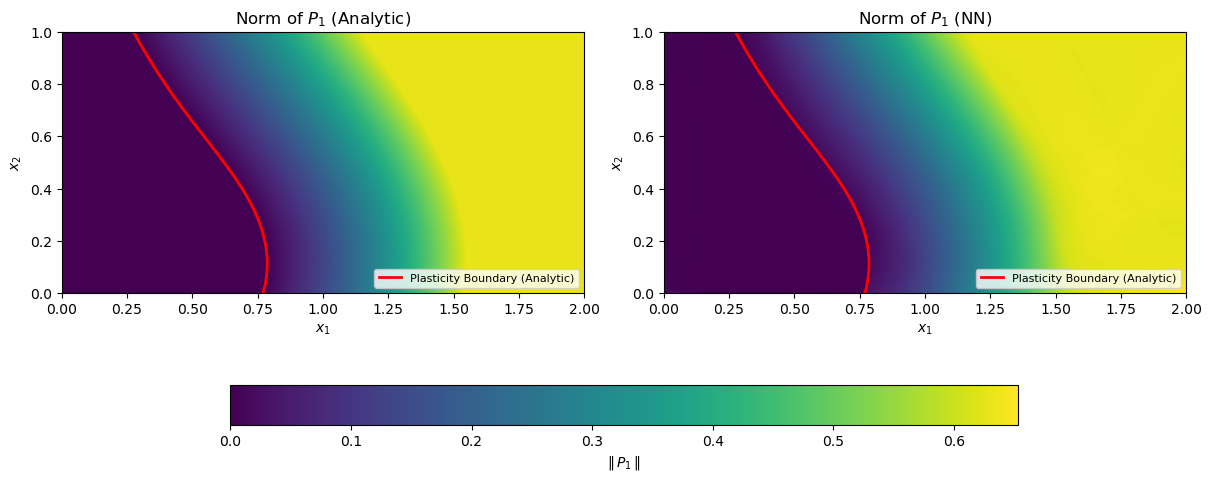

In [59]:
# Visualize real vs NN-generated P_norm
# Calculate the shared color range
vmin = 0
vmax = max(norms_P1_grid.max(), norms_P1_nn_grid.max())

# Enable constrained layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Norms from the analytic
im1 = ax1.imshow(
    norms_P1_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
ax1.set_title("Norm of $P_1$ (Analytic)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.plot(boundary_P1_x1, boundary_P1_x2, 'r-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Norms from the NN
im2 = ax2.imshow(
    norms_P1_nn_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
ax2.set_title("Norm of $P_1$ (NN)")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.plot(boundary_P1_x1, boundary_P1_x2, 'r-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Add a legend to both subplots
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a common colorbar automatically
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink = 0.7)
cbar.set_label(r"$\|\,P_1\,\|$")

# Save the figure
plt.savefig("../images/multi-yield/P1_norm_comparison_analytic_vs_nn.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

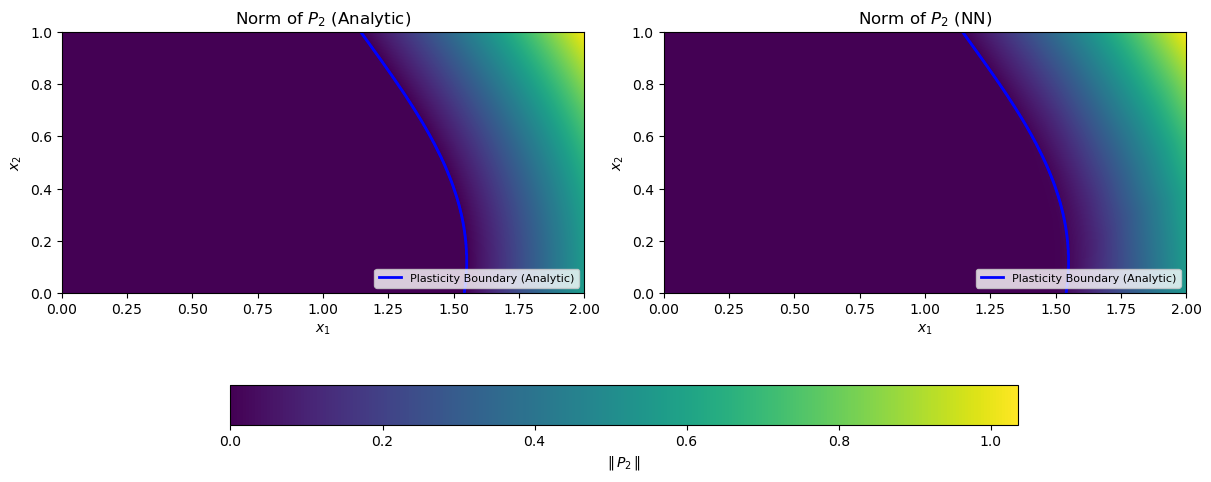

In [60]:
# Visualize real vs NN-generated P_norm
# Calculate the shared color range
vmin = 0
vmax = max(norms_P2_grid.max(), norms_P2_nn_grid.max())

# Enable constrained layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Norms from the analytic
im1 = ax1.imshow(
    norms_P2_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
ax1.set_title("Norm of $P_2$ (Analytic)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.plot(boundary_P2_x1, boundary_P2_x2, 'b-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Norms from the NN
im2 = ax2.imshow(
    norms_P2_nn_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
ax2.set_title("Norm of $P_2$ (NN)")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.plot(boundary_P2_x1, boundary_P2_x2, 'b-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Add a legend to both subplots
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a common colorbar automatically
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink = 0.7)
cbar.set_label(r"$\|\,P_2\,\|$")

# Save the figure
plt.savefig("../images/multi-yield/P2_norm_comparison_analytic_vs_nn.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

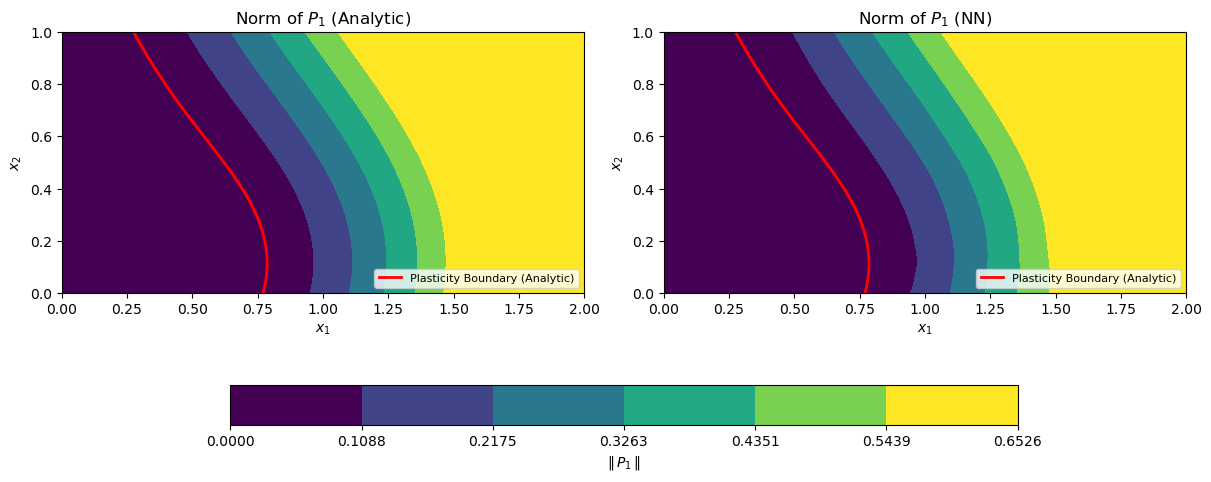

In [61]:
vmax = max(norms_P1_grid.max(), norms_P1_nn_grid.max())
# Define discrete levels for colormap
levels = np.linspace(0, vmax, 7)  # Adjust the number of levels as needed
cmap = plt.get_cmap("viridis", len(levels) - 1)  # Discretize colormap
norm = mcolors.BoundaryNorm(levels, cmap.N)  # Normalize to discrete levels

# Enable constrained layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Norms from the analytic
im1 = ax1.imshow(
    norms_P1_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,  # Use discrete colormap
    norm=norm   # Apply discrete levels
)
ax1.set_title("Norm of $P_1$ (Analytic)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.plot(boundary_P1_x1, boundary_P1_x2, 'r-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Norms from the NN
im2 = ax2.imshow(
    norms_P1_nn_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,  # Use discrete colormap
    norm=norm   # Apply discrete levels
)
ax2.set_title("Norm of $P_1$ (NN)")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.plot(boundary_P1_x1, boundary_P1_x2, 'r-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Add a legend to both subplots
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a common colorbar with discrete ticks
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink=0.7, ticks=levels)
cbar.set_label(r"$\|\,P_1\,\|$")

# Save the figure
plt.savefig("../images/multi-yield/P1_norm_comparison_analytic_vs_nn_discrete.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

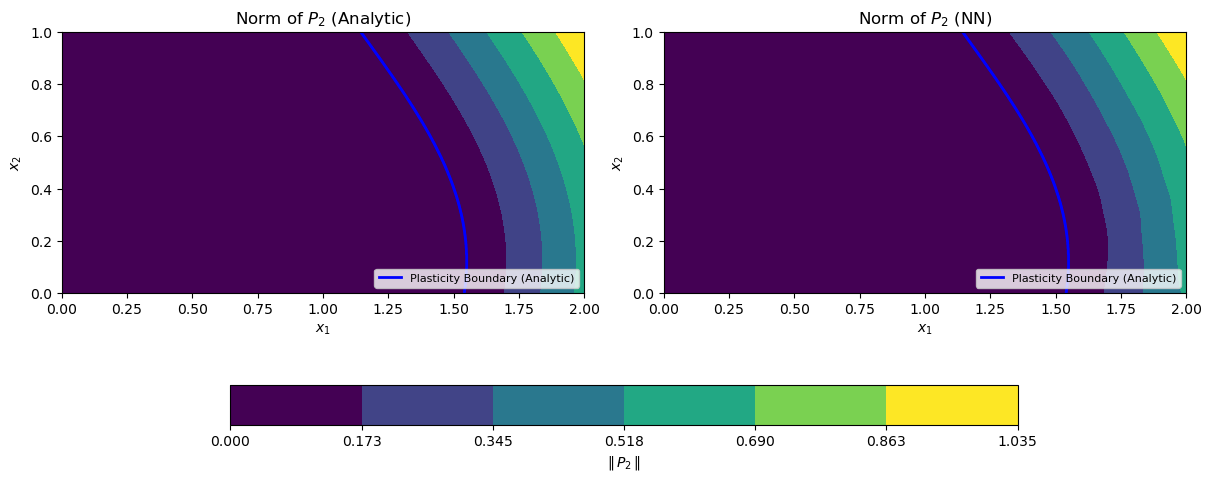

In [62]:
vmax = max(norms_P2_grid.max(), norms_P2_nn_grid.max())
# Define discrete levels for colormap
levels = np.linspace(0, vmax, 7)  # Adjust the number of levels as needed
cmap = plt.get_cmap("viridis", len(levels) - 1)  # Discretize colormap
norm = mcolors.BoundaryNorm(levels, cmap.N)  # Normalize to discrete levels

# Enable constrained layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Norms from the analytic
im1 = ax1.imshow(
    norms_P2_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,  # Use discrete colormap
    norm=norm   # Apply discrete levels
)
ax1.set_title("Norm of $P_2$ (Analytic)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.plot(boundary_P2_x1, boundary_P2_x2, 'b-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Norms from the NN
im2 = ax2.imshow(
    norms_P2_nn_grid,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,  # Use discrete colormap
    norm=norm   # Apply discrete levels
)
ax2.set_title("Norm of $P_2$ (NN)")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")
ax2.plot(boundary_P2_x1, boundary_P2_x2, 'b-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Add a legend to both subplots
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a common colorbar with discrete ticks
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink=0.7, ticks=levels)
cbar.set_label(r"$\|\,P_2\,\|$")

# Save the figure
plt.savefig("../images/multi-yield/P2_norm_comparison_analytic_vs_nn_discrete.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

In [63]:
# Compute absolute difference in norms
delta_P1 = np.abs(norms_P1_grid - norms_P1_nn_grid)
print(f"Max difference: {np.max(delta_P1):.6f}")

Max difference: 0.087778


In [64]:
delta_P2 = np.abs(norms_P2_grid - norms_P2_nn_grid)
print(f"Max difference: {np.max(delta_P2):.6f}")

Max difference: 0.284250


- Calculate mean absolute and mean absolute relative error

In [65]:
# MAE: mean absolute error
mae_P1 = np.mean(delta_P1)
mae_P2 = np.mean(delta_P2)

print(f"MAE P1: {mae_P1:.6f}")
print(f"MAE P2: {mae_P2:.6f}")

MAE P1: 0.002607
MAE P2: 0.001831


In [66]:
# MARE: mean absolute relative error
eps = 1e-8  # to avoid dividing by zero
mare_P1 = np.mean(delta_P1 / (np.abs(norms_P1_grid) + eps))
mare_P2 = np.mean(delta_P2 / (np.abs(norms_P2_grid) + eps))

print(f"MARE P1: {mare_P1:.6f}")
print(f"MARE P2: {mare_P2:.6f}")

MARE P1: 49844.788289
MARE P2: 90073.013243


The mean absolute error for both $P_1$ and $P_2$ is quite small, but the mean absolute relative error explodes because a large fraction of the reference $P_1$ and $P_2$ values are exactly zero. Division by these near-zero entries makes the relative error arbitrarily large.

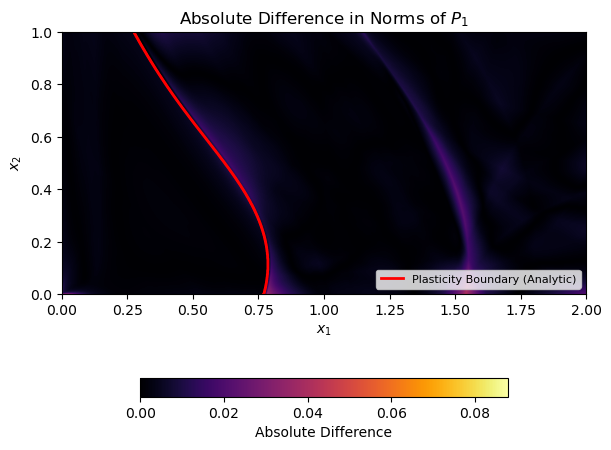

In [67]:
# Define color range
vmin = 0
vmax = np.max(delta_P1)

# Enable constrained layout
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

# Plot the absolute difference
im = ax.imshow(
    delta_P1,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap="inferno",  # A good colormap for visualizing differences
    vmin=vmin,
    vmax=vmax
)

ax.set_title("Absolute Difference in Norms of $P_1$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

# Add plasticity boundary
ax.plot(boundary_P1_x1, boundary_P1_x2, 'r-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Add legend
ax.legend(loc="lower right", fontsize=8)

# Add a colorbar below the plot
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.1, shrink=0.7)
cbar.set_label("Absolute Difference")

# Save the figure
plt.savefig("../images/multi-yield/P1_absolute_difference_analytic_vs_nn.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()


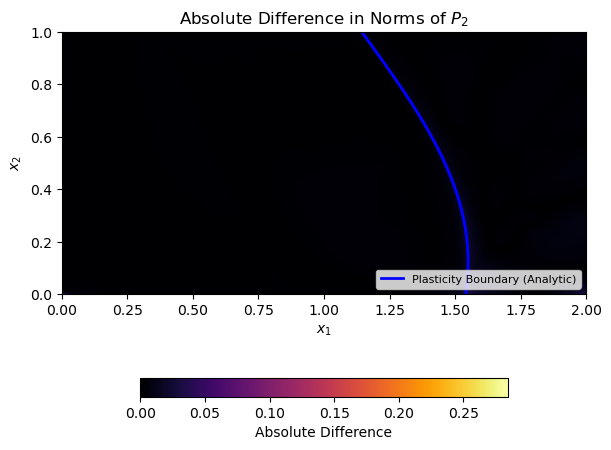

In [68]:
# Define color range
vmin = 0
vmax = np.max(delta_P2)

# Enable constrained layout
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

# Plot the absolute difference
im = ax.imshow(
    delta_P2,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap="inferno",  # A good colormap for visualizing differences
    vmin=vmin,
    vmax=vmax
)

ax.set_title("Absolute Difference in Norms of $P_2$")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

# Add plasticity boundary
ax.plot(boundary_P2_x1, boundary_P2_x2, 'b-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Add legend
ax.legend(loc="lower right", fontsize=8)

# Add a colorbar below the plot
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.1, shrink=0.7)
cbar.set_label("Absolute Difference")

# Save the figure
plt.savefig("../images/multi-yield/P2_absolute_difference_analytic_vs_nn.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

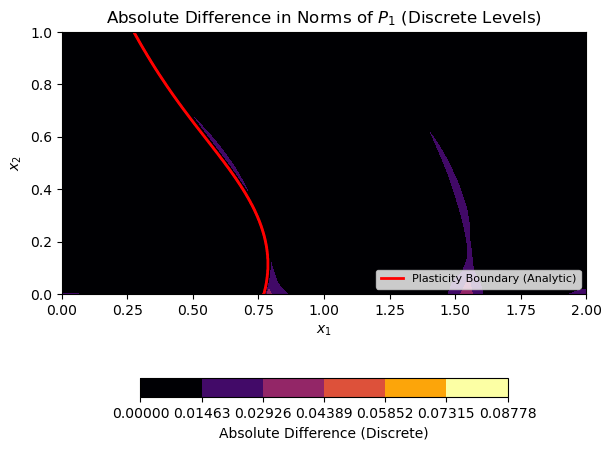

In [69]:
# Define discrete color levels
num_levels = 7
levels = np.linspace(0, np.max(delta_P1), num_levels)
cmap = plt.get_cmap("inferno")
norm = mcolors.BoundaryNorm(levels, cmap.N)

# Enable constrained layout
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

# Plot the absolute difference with discrete colors
im = ax.imshow(
    delta_P1,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,  # use discrete map
    norm=norm
)

ax.set_title("Absolute Difference in Norms of $P_1$ (Discrete Levels)")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

# Add plasticity boundary
ax.plot(boundary_P1_x1, boundary_P1_x2, 'r-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Add legend
ax.legend(loc="lower right", fontsize=8)

# Add a colorbar with discrete ticks
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.1, shrink=0.7, ticks=levels)
cbar.set_label("Absolute Difference (Discrete)")

# Save the figure
plt.savefig("../images/multi-yield/P1_absolute_difference_analytic_vs_nn_discrete.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

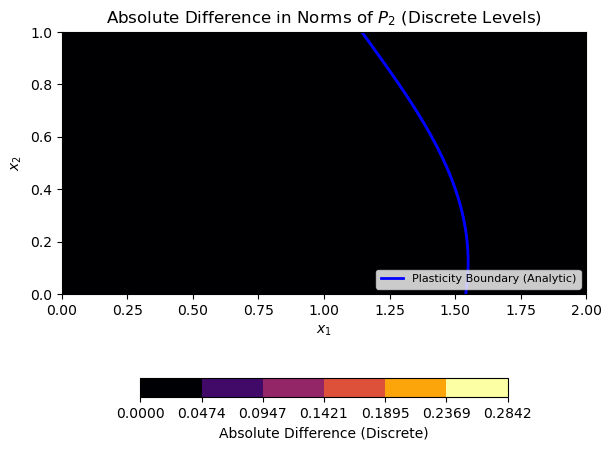

In [70]:
# Define discrete color levels
num_levels = 7
levels = np.linspace(0, np.max(delta_P2), num_levels)
cmap = plt.get_cmap("inferno")
norm = mcolors.BoundaryNorm(levels, cmap.N)

# Enable constrained layout
fig, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)

# Plot the absolute difference with discrete colors
im = ax.imshow(
    delta_P2,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,  # use discrete map
    norm=norm
)

ax.set_title("Absolute Difference in Norms of $P_2$ (Discrete Levels)")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

# Add plasticity boundary
ax.plot(boundary_P2_x1, boundary_P2_x2, 'b-', linewidth=2, label="Plasticity Boundary (Analytic)")

# Add legend
ax.legend(loc="lower right", fontsize=8)

# Add a colorbar with discrete ticks
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.1, shrink=0.7, ticks=levels)
cbar.set_label("Absolute Difference (Discrete)")

# Save the figure
plt.savefig("../images/multi-yield/P2_absolute_difference_analytic_vs_nn_discrete.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

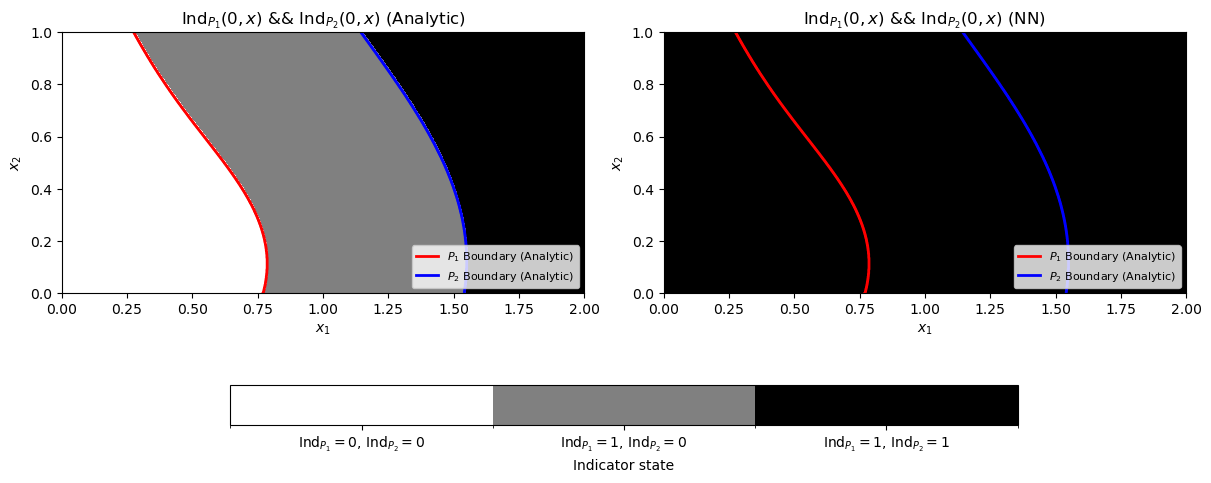

In [71]:
# Compute indicator matrices for analytic and NN-based results
alpha = 0  # Threshold for defining plasticity
indicator_P1_analytic = (norms_P1_grid > 0).astype(int)
indicator_P2_analytic = (norms_P2_grid > 0).astype(int)

indicator_P1_nn = (norms_P1_nn_grid > alpha).astype(int)
indicator_P2_nn = (norms_P2_nn_grid > alpha).astype(int)

# Compute the combined indicator state
# 0 – No plasticity (both P1 and P2 are 0)
# 1 – First threshold exceeded (P1 > 0, P2 == 0)
# 2 – Second threshold exceeded (both P1 > 0 and P2 > 0)
indicator_analytic = np.zeros_like(indicator_P1_analytic)
indicator_analytic[(indicator_P1_analytic > 0) & (indicator_P2_analytic == 0)] = 1
indicator_analytic[(indicator_P1_analytic > 0) & (indicator_P2_analytic > 0)] = 2

indicator_nn = np.zeros_like(indicator_P1_nn)
indicator_nn[(indicator_P1_nn > 0) & (indicator_P2_nn == 0)] = 1
indicator_nn[(indicator_P1_nn > 0) & (indicator_P2_nn > 0)] = 2

# Define discrete colormap
cmap = mcolors.ListedColormap(["white", "gray", "black"])  # White for 0, Gray for 1, Black for 2
bounds = [0, 1, 2, 3]  # Boundaries between classes
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot indicators with the boundary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Analytic-based Indicator
im1 = ax1.imshow(
    indicator_analytic,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)
ax1.set_title(r"$\mathrm{Ind}_{P_1}(0,x)$ && $\mathrm{Ind}_{P_2}(0,x)$ (Analytic)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")

# Add boundaries: Red for P1, Blue for P2
ax1.plot(boundary_P1_x1, boundary_P1_x2, 'r-', linewidth=2, label="$P_1$ Boundary (Analytic)")
ax1.plot(boundary_P2_x1, boundary_P2_x2, 'b-', linewidth=2, label="$P_2$ Boundary (Analytic)")

# NN-based Indicator
im2 = ax2.imshow(
    indicator_nn,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)
ax2.set_title(rf"$\mathrm{{Ind}}_{{P_1}}({alpha},x)$ && $\mathrm{{Ind}}_{{P_2}}({alpha},x)$ (NN)")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")

# Add boundaries: Red for P1, Blue for P2
ax2.plot(boundary_P1_x1, boundary_P1_x2, 'r-', linewidth=2, label="$P_1$ Boundary (Analytic)")
ax2.plot(boundary_P2_x1, boundary_P2_x2, 'b-', linewidth=2, label="$P_2$ Boundary (Analytic)")

# Add legends
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a common discrete colorbar below both subplots
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink=0.7, ticks=[0.5, 1.5, 2.5])
cbar.set_ticklabels([
    "Ind$_{P_1}=0$, Ind$_{P_2}=0$",
    "Ind$_{P_1}=1$, Ind$_{P_2}=0$",
    "Ind$_{P_1}=1$, Ind$_{P_2}=1$",
])
cbar.set_label("Indicator state")

# Save the figure
plt.savefig(f"../images/multi-yield/Ind_{alpha}_comparison_analytic_with_boundary.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

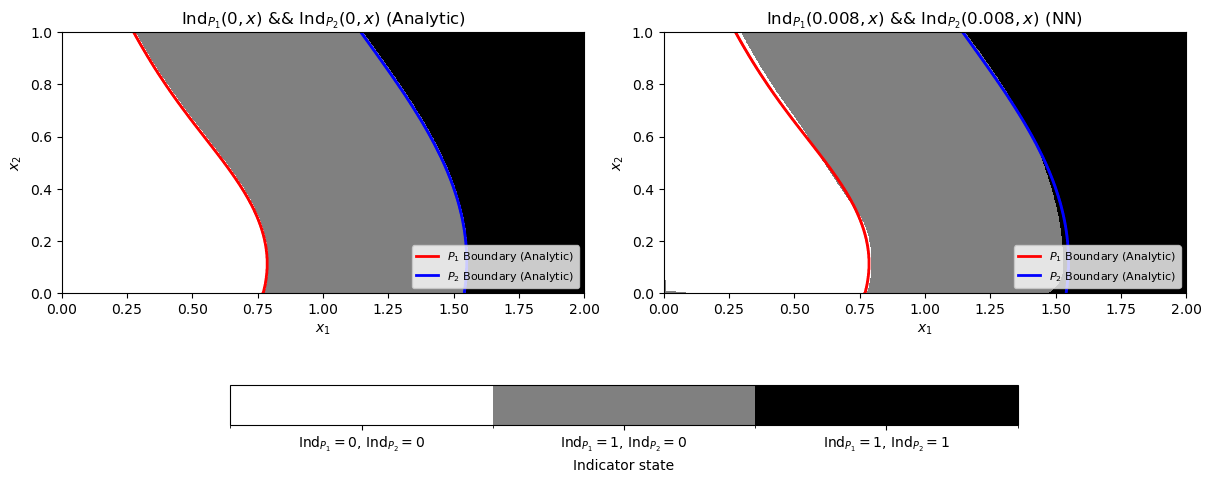

In [72]:
# Compute indicator matrices for analytic and NN-based results
alpha = 0.008  # Threshold for defining plasticity
indicator_P1_analytic = (norms_P1_grid > 0).astype(int)
indicator_P2_analytic = (norms_P2_grid > 0).astype(int)

indicator_P1_nn = (norms_P1_nn_grid > alpha).astype(int)
indicator_P2_nn = (norms_P2_nn_grid > alpha).astype(int)

# Compute the combined indicator state
# 0 – No plasticity (both P1 and P2 are 0)
# 1 – First threshold exceeded (P1 > 0, P2 == 0)
# 2 – Second threshold exceeded (both P1 > 0 and P2 > 0)
indicator_analytic = np.zeros_like(indicator_P1_analytic)
indicator_analytic[(indicator_P1_analytic > 0) & (indicator_P2_analytic == 0)] = 1
indicator_analytic[(indicator_P1_analytic > 0) & (indicator_P2_analytic > 0)] = 2

indicator_nn = np.zeros_like(indicator_P1_nn)
indicator_nn[(indicator_P1_nn > 0) & (indicator_P2_nn == 0)] = 1
indicator_nn[(indicator_P1_nn > 0) & (indicator_P2_nn > 0)] = 2

# Define discrete colormap
cmap = mcolors.ListedColormap(["white", "gray", "black"])  # White for 0, Gray for 1, Black for 2
bounds = [0, 1, 2, 3]  # Boundaries between classes
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot indicators with the boundary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Analytic-based Indicator
im1 = ax1.imshow(
    indicator_analytic,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)
ax1.set_title(r"$\mathrm{Ind}_{P_1}(0,x)$ && $\mathrm{Ind}_{P_2}(0,x)$ (Analytic)")
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")

# Add boundaries: Red for P1, Blue for P2
ax1.plot(boundary_P1_x1, boundary_P1_x2, 'r-', linewidth=2, label="$P_1$ Boundary (Analytic)")
ax1.plot(boundary_P2_x1, boundary_P2_x2, 'b-', linewidth=2, label="$P_2$ Boundary (Analytic)")

# NN-based Indicator
im2 = ax2.imshow(
    indicator_nn,
    extent=(x1_min, x1_max, x2_min, x2_max),
    origin='lower',
    cmap=cmap,
    norm=norm
)
ax2.set_title(rf"$\mathrm{{Ind}}_{{P_1}}({alpha},x)$ && $\mathrm{{Ind}}_{{P_2}}({alpha},x)$ (NN)")
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("$x_2$")

# Add boundaries: Red for P1, Blue for P2
ax2.plot(boundary_P1_x1, boundary_P1_x2, 'r-', linewidth=2, label="$P_1$ Boundary (Analytic)")
ax2.plot(boundary_P2_x1, boundary_P2_x2, 'b-', linewidth=2, label="$P_2$ Boundary (Analytic)")

# Add legends
ax1.legend(loc="lower right", fontsize=8)
ax2.legend(loc="lower right", fontsize=8)

# Add a common discrete colorbar below both subplots
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink=0.7, ticks=[0.5, 1.5, 2.5])
cbar.set_ticklabels([
    "Ind$_{P_1}=0$, Ind$_{P_2}=0$",
    "Ind$_{P_1}=1$, Ind$_{P_2}=0$",
    "Ind$_{P_1}=1$, Ind$_{P_2}=1$",
])
cbar.set_label("Indicator state")

# Save the figure
plt.savefig(f"../images/multi-yield/Ind_{alpha}_comparison_analytic_with_boundary.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

## Deformed grid

In [73]:
Y1 = X1 + U1
Y2 = X2 + U2

In [74]:
points_x = Y1.flatten()
points_y = Y2.flatten()

In [75]:
# Create triangulation
triangles = tri.Triangulation(points_x, points_y)

In [76]:
num_triangles = len(triangles.triangles)
print(f"Number of triangles: {num_triangles}")

Number of triangles: 3234602


In [77]:
p1_flat_analytic = norms_P1_grid.flatten()
p2_flat_analytic = norms_P2_grid.flatten()
p1_ind_flat_analytic = indicator_norm_P1.flatten()
p2_ind_flat_analytic = indicator_norm_P2.flatten()

In [78]:
p1_flat_nn = norms_P1_nn_grid.flatten()
p2_flat_nn = norms_P2_nn_grid.flatten()

In [79]:
p1_tri_analytic = p1_flat_analytic[triangles.triangles].mean(axis=1)
p2_tri_analytic = p2_flat_analytic[triangles.triangles].mean(axis=1)

In [80]:
ind1_tri_analytic = (p1_ind_flat_analytic[triangles.triangles].sum(axis=1) > 0).astype(int)
ind2_tri_analytic = (p2_ind_flat_analytic[triangles.triangles].sum(axis=1) > 0).astype(int)

In [81]:
p1_tri_nn = p1_flat_nn[triangles.triangles].mean(axis=1)
p2_tri_nn = p2_flat_nn[triangles.triangles].mean(axis=1)

### P norm comparison

In [82]:
# Calculate indicator norms (analytic)
indicator_norm_P1_tri = (p1_tri_analytic > 0).astype(int)
indicator_norm_P2_tri = (p2_tri_analytic > 0).astype(int)

In [83]:
# Initialize storage for boundary edges
edges_P1 = []  # Boundary edges for P1
edges_P2 = []  # Boundary edges for P2

# Loop through all triangles and their neighbors
for tri_idx, neighbors in enumerate(triangles.neighbors):
    for side, neighbor_idx in enumerate(neighbors):
        if neighbor_idx != -1:
            # If the indicators are different, it's on the border
            if indicator_norm_P1_tri[tri_idx] != indicator_norm_P1_tri[neighbor_idx]:
                # Get the indexes of the nodes of the current side
                i1 = triangles.triangles[tri_idx][side]
                i2 = triangles.triangles[tri_idx][(side + 1) % 3]
                edges_P1.append((points_x[i1], points_y[i1], points_x[i2], points_y[i2]))

            if indicator_norm_P2_tri[tri_idx] != indicator_norm_P2_tri[neighbor_idx]:
                i1 = triangles.triangles[tri_idx][side]
                i2 = triangles.triangles[tri_idx][(side + 1) % 3]
                edges_P2.append((points_x[i1], points_y[i1], points_x[i2], points_y[i2]))

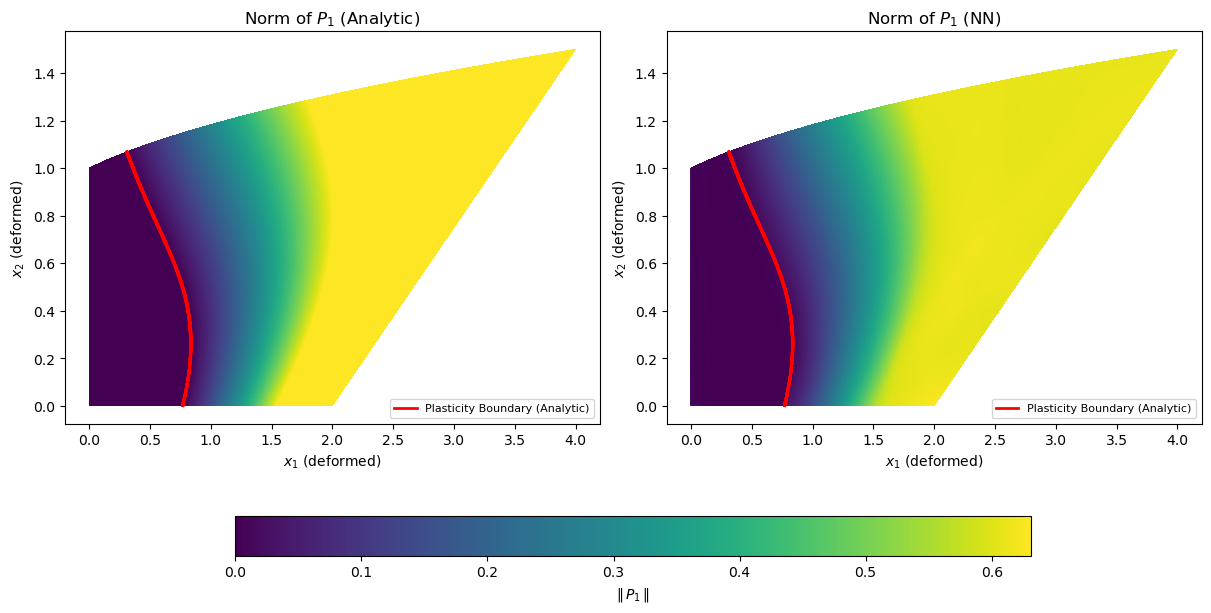

In [84]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# -------------------------
# Plot P1 norm (Analytic)
# -------------------------
im1 = ax1.tripcolor(
    triangles, p1_tri_analytic, cmap="viridis", shading="flat"
)
ax1.set_title("Norm of $P_1$ (Analytic)")
ax1.set_xlabel("$x_1$ (deformed)")
ax1.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for P1
for i, (x1, y1, x2, y2) in enumerate(edges_P1):
    # Add label only for the first line, so it appears once in the legend
    label = "Plasticity Boundary (Analytic)" if i == 0 else None
    ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label=label)

# Add legend
ax1.legend(loc="lower right", fontsize=8)
# -------------------------
# Plot P1 norm (NN)
# -------------------------
im2 = ax2.tripcolor(
    triangles, p1_tri_nn, cmap="viridis", shading="flat"
)
ax2.set_title("Norm of $P_1$ (NN)")
ax2.set_xlabel("$x_1$ (deformed)")
ax2.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for P1
for i, (x1, y1, x2, y2) in enumerate(edges_P1):
    # Add label only for the first line, so it appears once in the legend
    label = "Plasticity Boundary (Analytic)" if i == 0 else None
    ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label=label)

# Add legend
ax2.legend(loc="lower right", fontsize=8)
# -------------------------
# Add a common colorbar below both subplots
# -------------------------
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink=0.7)
cbar.set_label(r"$\|\,P_1\,\|$")

# Save the figure (uncomment if needed)
plt.savefig("../images/multi-yield/P1_norm_comparison_analytic_vs_nn_deformed.png", format="png", dpi = 300, bbox_inches="tight")

# Show plot
plt.show()


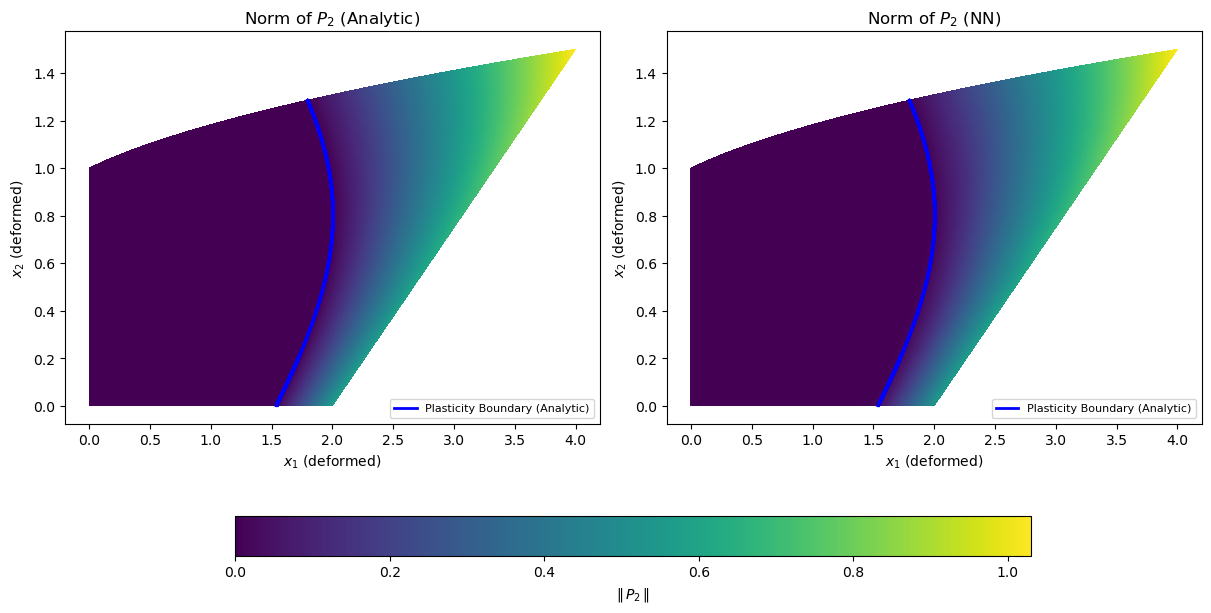

In [85]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# -------------------------
# Plot P2 norm (Analytic)
# -------------------------
im1 = ax1.tripcolor(
    triangles, p2_tri_analytic, cmap="viridis", shading="flat"
)
ax1.set_title("Norm of $P_2$ (Analytic)")
ax1.set_xlabel("$x_1$ (deformed)")
ax1.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for P2
for i, (x1, y1, x2, y2) in enumerate(edges_P2):
    # Add label only for the first line, so it appears once in the legend
    label = "Plasticity Boundary (Analytic)" if i == 0 else None
    ax1.plot([x1, x2], [y1, y2], 'b-', linewidth=2, label=label)

# Add legend
ax1.legend(loc="lower right", fontsize=8)
# -------------------------
# Plot P2 norm (NN)
# -------------------------
im2 = ax2.tripcolor(
    triangles, p2_tri_nn, cmap="viridis", shading="flat"
)
ax2.set_title("Norm of $P_2$ (NN)")
ax2.set_xlabel("$x_1$ (deformed)")
ax2.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for P2
for i, (x1, y1, x2, y2) in enumerate(edges_P2):
    # Add label only for the first line, so it appears once in the legend
    label = "Plasticity Boundary (Analytic)" if i == 0 else None
    ax2.plot([x1, x2], [y1, y2], 'b-', linewidth=2, label=label)

# Add legend
ax2.legend(loc="lower right", fontsize=8)
# -------------------------
# Add a common colorbar below both subplots
# -------------------------
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink=0.7)
cbar.set_label(r"$\|\,P_2\,\|$")

# Save the figure (uncomment if needed)
plt.savefig("../images/multi-yield/P2_norm_comparison_analytic_vs_nn_deformed.png", format="png", dpi = 300, bbox_inches="tight")

# Show plot
plt.show()


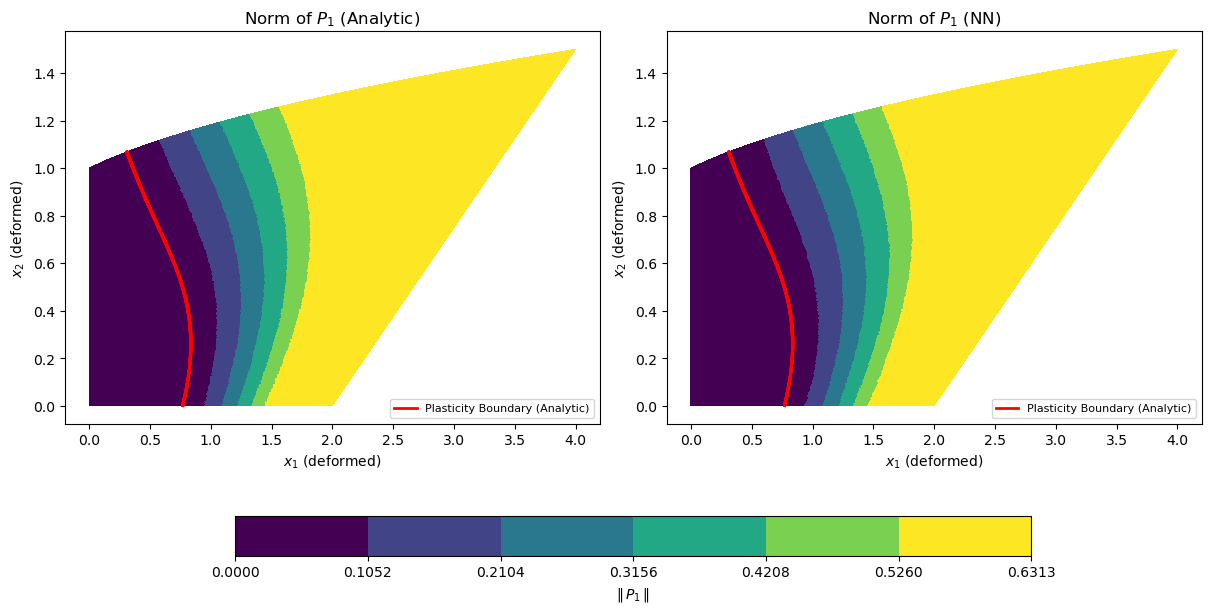

In [86]:
# Define discrete levels for colormap
levels = np.linspace(0, np.max(p1_tri_analytic), 7)  # Adjust number of levels
cmap = plt.get_cmap("viridis", len(levels) - 1)  # Discretized colormap
norm = mcolors.BoundaryNorm(levels, cmap.N)  # Normalize to discrete levels

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# -------------------------
# Plot P1 norm (Analytic)
# -------------------------
im1 = ax1.tripcolor(
    triangles, p1_tri_analytic, cmap=cmap, norm=norm, shading="flat"  # Discrete colors
)
ax1.set_title("Norm of $P_1$ (Analytic)")
ax1.set_xlabel("$x_1$ (deformed)")
ax1.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for P1
for i, (x1, y1, x2, y2) in enumerate(edges_P1):
    # Add label only for the first line, so it appears once in the legend
    label = "Plasticity Boundary (Analytic)" if i == 0 else None
    ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label=label)

# Add legend
ax1.legend(loc="lower right", fontsize=8)
# -------------------------
# Plot P1 norm (NN)
# -------------------------
im2 = ax2.tripcolor(
    triangles, p1_tri_nn, cmap=cmap, norm=norm, shading="flat"  # Discrete colors
)
ax2.set_title("Norm of $P_1$ (NN)")
ax2.set_xlabel("$x_1$ (deformed)")
ax2.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for P1
for i, (x1, y1, x2, y2) in enumerate(edges_P1):
    # Add label only for the first line, so it appears once in the legend
    label = "Plasticity Boundary (Analytic)" if i == 0 else None
    ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label=label)

# Add legend
ax2.legend(loc="lower right", fontsize=8)

# -------------------------
# Add a common discrete colorbar below both subplots
# -------------------------
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink=0.7, ticks=levels)
cbar.set_label(r"$\|\,P_1\,\|$")

# Save the figure (uncomment if needed)
plt.savefig("../images/multi-yield/P1_norm_comparison_analytic_vs_nn_discrete_deformed.png", format="png", dpi = 300, bbox_inches="tight")

# Show plot
plt.show()


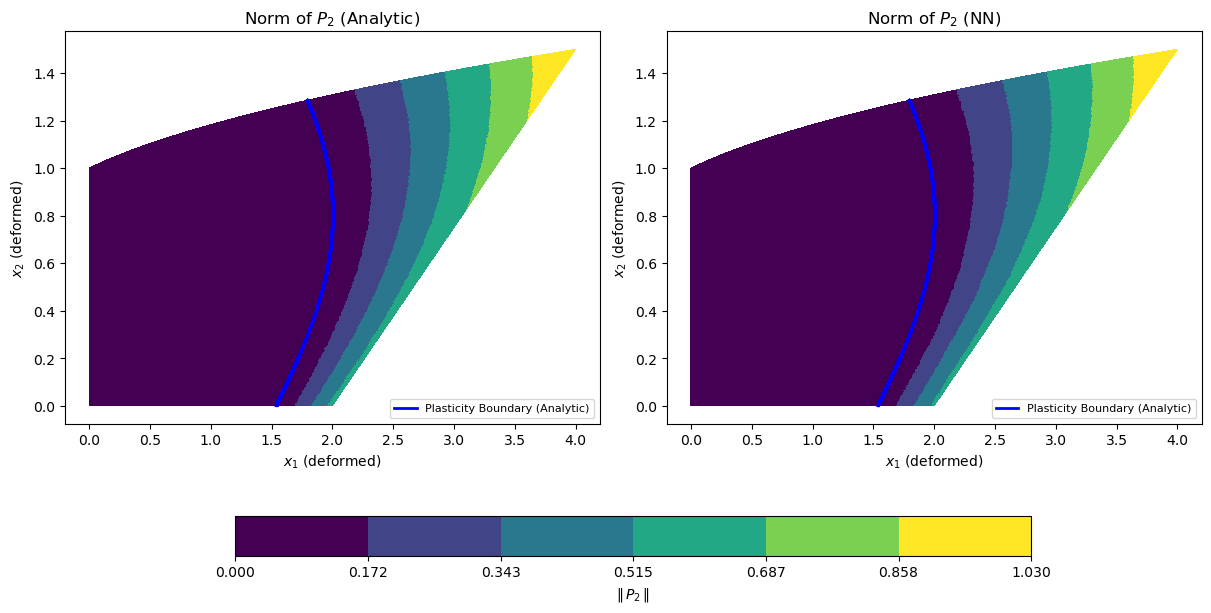

In [87]:
# Define discrete levels for colormap
levels = np.linspace(0, np.max(p2_tri_analytic), 7)  # Adjust number of levels
cmap = plt.get_cmap("viridis", len(levels) - 1)  # Discretized colormap
norm = mcolors.BoundaryNorm(levels, cmap.N)  # Normalize to discrete levels

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# -------------------------
# Plot P2 norm (Analytic)
# -------------------------
im1 = ax1.tripcolor(
    triangles, p2_tri_analytic, cmap=cmap, norm=norm, shading="flat"  # Discrete colors
)
ax1.set_title("Norm of $P_2$ (Analytic)")
ax1.set_xlabel("$x_1$ (deformed)")
ax1.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for P2
for i, (x1, y1, x2, y2) in enumerate(edges_P2):
    # Add label only for the first line, so it appears once in the legend
    label = "Plasticity Boundary (Analytic)" if i == 0 else None
    ax1.plot([x1, x2], [y1, y2], 'b-', linewidth=2, label=label)

# Add legend
ax1.legend(loc="lower right", fontsize=8)
# -------------------------
# Plot P2 norm (NN)
# -------------------------
im2 = ax2.tripcolor(
    triangles, p2_tri_nn, cmap=cmap, norm=norm, shading="flat"  # Discrete colors
)
ax2.set_title("Norm of $P_2$ (NN)")
ax2.set_xlabel("$x_1$ (deformed)")
ax2.set_ylabel("$x_2$ (deformed)")

# Add plasticity boundary for P2
for i, (x1, y1, x2, y2) in enumerate(edges_P2):
    # Add label only for the first line, so it appears once in the legend
    label = "Plasticity Boundary (Analytic)" if i == 0 else None
    ax2.plot([x1, x2], [y1, y2], 'b-', linewidth=2, label=label)

# Add legend
ax2.legend(loc="lower right", fontsize=8)
# -------------------------
# Add a common discrete colorbar below both subplots
# -------------------------
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink=0.7, ticks=levels)
cbar.set_label(r"$\|\,P_2\,\|$")

# Save the figure (uncomment if needed)
plt.savefig("../images/multi-yield/P2_norm_comparison_analytic_vs_nn_discrete_deformed.png", format="png", dpi = 300, bbox_inches="tight")

# Show plot
plt.show()

In [88]:
delta_P1_deformed = np.abs(p1_tri_nn - p1_tri_analytic)
print(f"Max difference: {np.max(delta_P1_deformed):.6f}")

Max difference: 0.061961


In [89]:
delta_P2_deformed = np.abs(p2_tri_nn - p2_tri_analytic)
print(f"Max difference: {np.max(delta_P2_deformed):.6f}")

Max difference: 0.166275


- Calculate mean absolute and mean absolute relative error

In [90]:
# MAE
mae_P1_deformed = np.mean(delta_P1_deformed)
mae_P2_deformed = np.mean(delta_P2_deformed)

print(f"MAE P1: {mae_P1_deformed:.6f}")
print(f"MAE P2: {mae_P2_deformed:.6f}")

MAE P1: 0.002599
MAE P2: 0.001824


In [91]:
mare_P1_deformed = np.mean(delta_P1_deformed / (p1_tri_analytic + eps))
mare_P2_deformed = np.mean(delta_P2_deformed / (p2_tri_analytic + eps))

print(f"MARE P1: {mare_P1_deformed}")
print(f"MARE P2: {mare_P2_deformed}")

MARE P1: 49073.6942203054
MARE P2: 88932.80770704611


- Here the error is slightly different, because of the way the triangulation was done. The triangles took the average value of the vertex points.

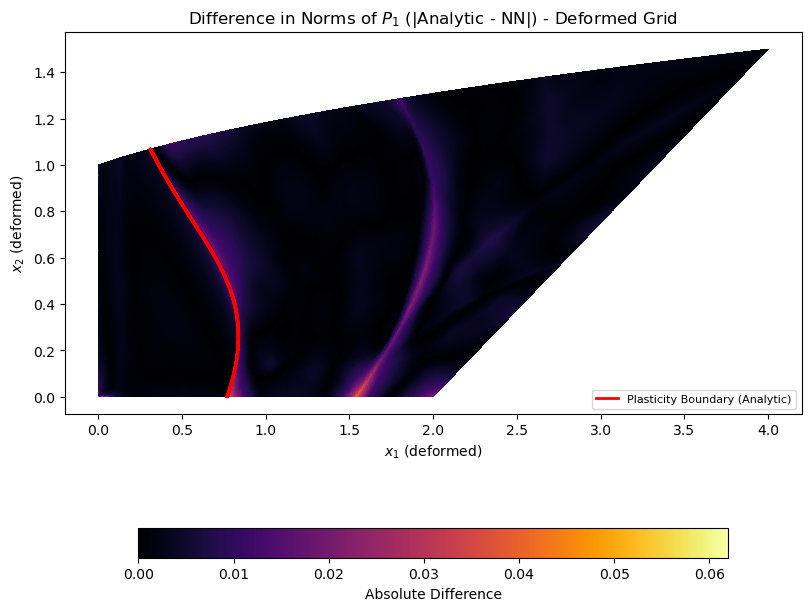

In [92]:
# Set up the plot
fig = plt.figure(figsize=(8, 6), constrained_layout=True)  # create fig

# Plot the difference on the deformed grid
im = plt.tripcolor(
    triangles,
    delta_P1_deformed,
    cmap="inferno",  # colormap
    vmin=0,  # minimal difference
    vmax=np.max(delta_P1_deformed)  # maximum difference
)

plt.title("Difference in Norms of $P_1$ (|Analytic - NN|) - Deformed Grid")
plt.xlabel("$x_1$ (deformed)")
plt.ylabel("$x_2$ (deformed)")

# Add plasticity boundary
first_edge = True
for x1, y1, x2, y2 in edges_P1:
    if first_edge:
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Analytic)")
        first_edge = False
    else:
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2)

# Add legend
plt.legend(loc="lower right", fontsize=8)

# Add a colorbar below the plot
cbar = fig.colorbar(im, orientation='horizontal', pad=0.15, shrink = 0.8)
cbar.set_label("Absolute Difference")

# Save
plt.savefig("../images/multi-yield/P1_norm_difference_analytic_vs_nn_deformed.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

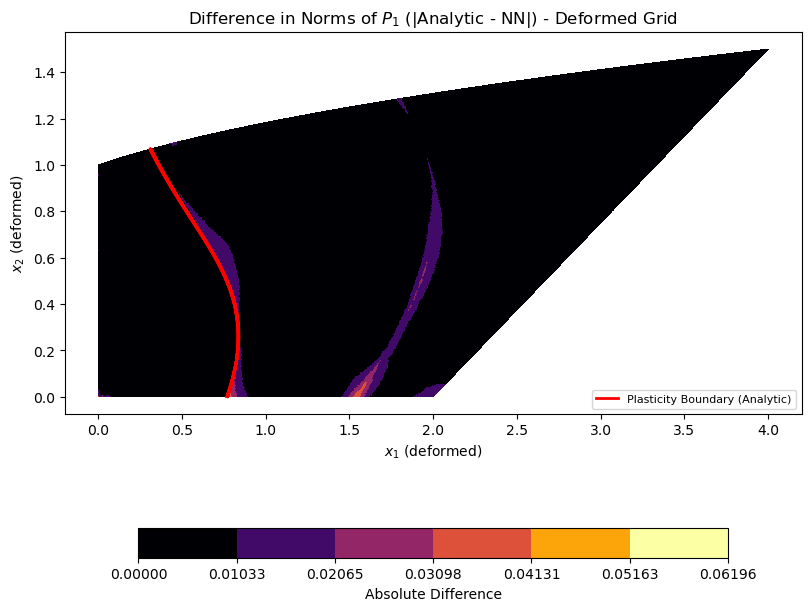

In [97]:
levels = np.linspace(0, np.max(delta_P1_deformed), 7)  # discrete levels from 0 to max difference
cmap = plt.get_cmap("inferno")  # Discrete colormap
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# Set up the plot
fig = plt.figure(figsize=(8, 6), constrained_layout=True)  # create fig

# Plot the difference on the deformed grid
im = plt.tripcolor(
    triangles,
    delta_P1_deformed,
    cmap=cmap,  # colormap
    norm = norm
)

plt.title("Difference in Norms of $P_1$ (|Analytic - NN|) - Deformed Grid")
plt.xlabel("$x_1$ (deformed)")
plt.ylabel("$x_2$ (deformed)")

# Add plasticity boundary
first_edge = True
for x1, y1, x2, y2 in edges_P1:
    if first_edge:
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Plasticity Boundary (Analytic)")
        first_edge = False
    else:
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2)

# Add legend
plt.legend(loc="lower right", fontsize=8)

# Add a colorbar below the plot
cbar = fig.colorbar(im, orientation='horizontal', pad=0.15, shrink = 0.8)
cbar.set_label("Absolute Difference")

# Save
plt.savefig("../images/multi-yield/P1_norm_difference_analytic_vs_nn_deformed_discrete.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

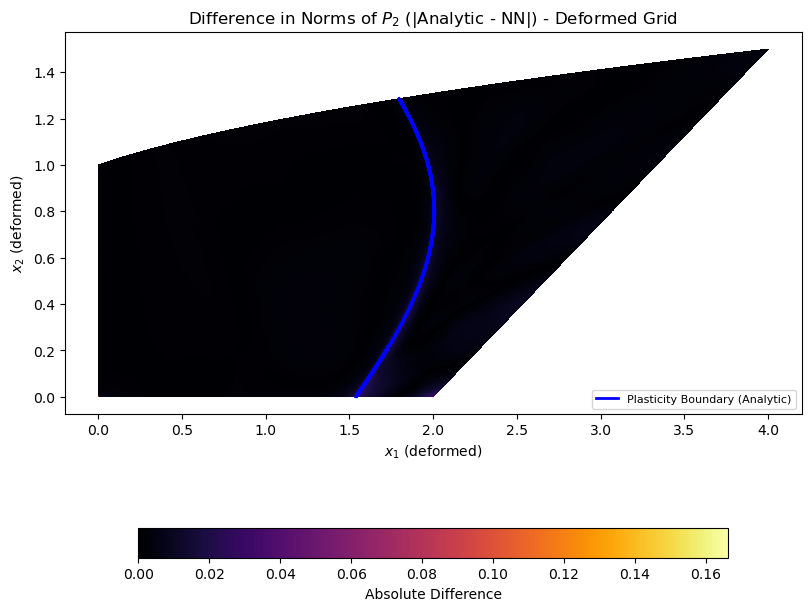

In [94]:
# Set up the plot
fig = plt.figure(figsize=(8, 6), constrained_layout=True)  # create fig

# Plot the difference on the deformed grid
im = plt.tripcolor(
    triangles,
    delta_P2_deformed,
    cmap="inferno",  # colormap
    vmin=0,  # minimal difference
    vmax=np.max(delta_P2_deformed)  # maximum difference
)

plt.title("Difference in Norms of $P_2$ (|Analytic - NN|) - Deformed Grid")
plt.xlabel("$x_1$ (deformed)")
plt.ylabel("$x_2$ (deformed)")

# Add plasticity boundary
first_edge = True
for x1, y1, x2, y2 in edges_P2:
    if first_edge:
        plt.plot([x1, x2], [y1, y2], 'b-', linewidth=2, label="Plasticity Boundary (Analytic)")
        first_edge = False
    else:
        plt.plot([x1, x2], [y1, y2], 'b-', linewidth=2)

# Add legend
plt.legend(loc="lower right", fontsize=8)

# Add a colorbar below the plot
cbar = fig.colorbar(im, orientation='horizontal', pad=0.15, shrink = 0.8)
cbar.set_label("Absolute Difference")

# Save
plt.savefig("../images/multi-yield/P2_norm_difference_analytic_vs_nn_deformed.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

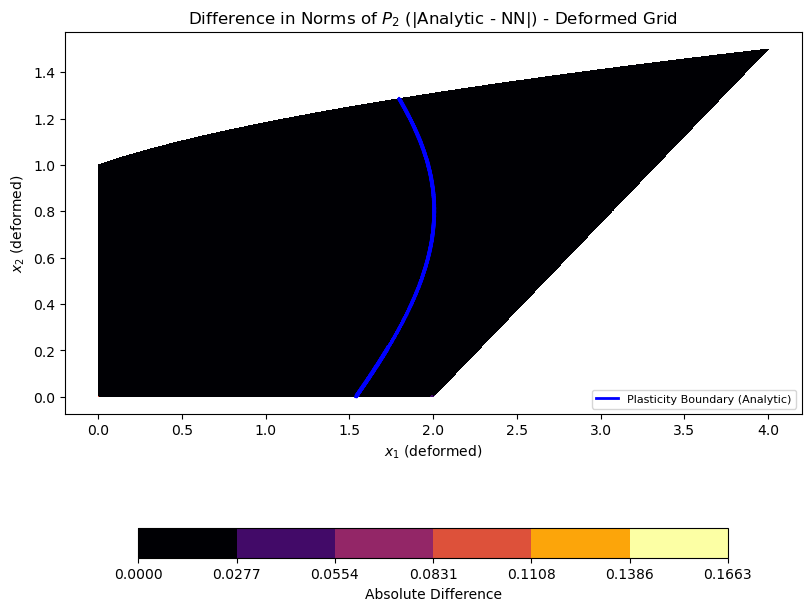

In [95]:
levels = np.linspace(0, np.max(delta_P2_deformed), 7)  # discrete levels from 0 to max difference
cmap = plt.get_cmap("inferno")  # Discrete colormap
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
# Set up the plot
fig = plt.figure(figsize=(8, 6), constrained_layout=True)  # create fig

# Plot the difference on the deformed grid
im = plt.tripcolor(
    triangles,
    delta_P2_deformed,
    cmap=cmap,  # colormap
    norm = norm
)

plt.title("Difference in Norms of $P_2$ (|Analytic - NN|) - Deformed Grid")
plt.xlabel("$x_1$ (deformed)")
plt.ylabel("$x_2$ (deformed)")

# Add plasticity boundary
first_edge = True
for x1, y1, x2, y2 in edges_P2:
    if first_edge:
        plt.plot([x1, x2], [y1, y2], 'b-', linewidth=2, label="Plasticity Boundary (Analytic)")
        first_edge = False
    else:
        plt.plot([x1, x2], [y1, y2], 'b-', linewidth=2)

# Add legend
plt.legend(loc="lower right", fontsize=8)

# Add a colorbar below the plot
cbar = fig.colorbar(im, orientation='horizontal', pad=0.15, shrink = 0.8)
cbar.set_label("Absolute Difference")

# Save
plt.savefig("../images/multi-yield/P2_norm_difference_analytic_vs_nn_deformed_discrete.png", format="png", dpi = 300, bbox_inches="tight")  # uncomment/comment to save/not to save
plt.show()

### Indicator norm comparison

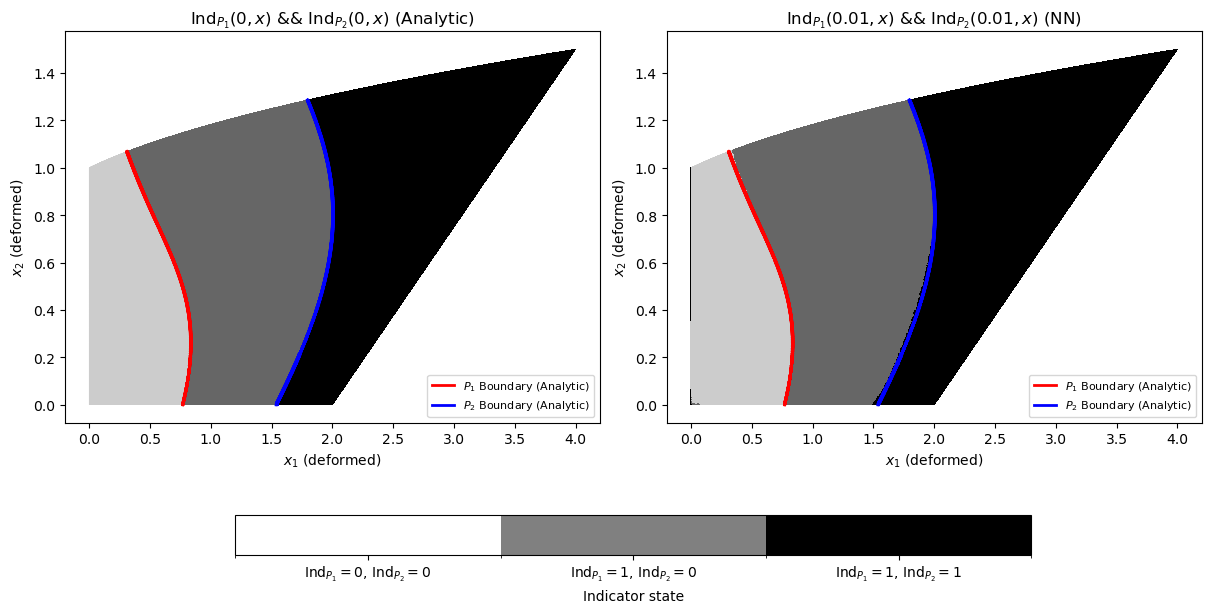

In [96]:
# Compute indicator matrices for analytic and NN-based results (deformed grid)
alpha = 0.01  # Threshold for defining plasticity#
indicator_P1_nn_tri = (p1_tri_nn > alpha).astype(int)
indicator_P2_nn_tri = (p2_tri_nn > alpha).astype(int)

# Compute the combined indicator state
# 0 – No plasticity (both P1 and P2 are 0)
# 1 – First threshold exceeded (P1 > 0, P2 == 0)
# 2 – Second threshold exceeded (both P1 > 0 and P2 > 0)
indicator_analytic_tri = np.zeros_like(indicator_norm_P1_tri)
indicator_analytic_tri[(indicator_norm_P1_tri> 0) & (indicator_norm_P2_tri == 0)] = 1
indicator_analytic_tri[(indicator_norm_P1_tri > 0) & (indicator_norm_P2_tri > 0)] = 2

indicator_nn_tri = np.zeros_like(indicator_P1_nn_tri)
indicator_nn_tri[(indicator_P1_nn_tri > 0) & (indicator_P2_nn_tri == 0)] = 1
indicator_nn_tri[(indicator_P1_nn_tri > 0) & (indicator_P2_nn_tri > 0)] = 2

# Define discrete colormap
cmap = mcolors.ListedColormap(["white", "gray", "black"])  # White for 0, Gray for 1, Black for 2
bounds = [0, 1, 2, 3]  # Boundaries between classes
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot indicators with the boundary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# -------------------------
# Analytic-based Indicator
# -------------------------
im1 = ax1.tripcolor(
    triangles, indicator_analytic_tri, cmap=cmap, norm=norm, shading="flat",
)
ax1.triplot(triangles, color='black', linewidth=0.2, alpha=0.2)
ax1.set_title(r"$\mathrm{Ind}_{P_1}(0,x)$ && $\mathrm{Ind}_{P_2}(0,x)$ (Analytic)")
ax1.set_xlabel("$x_1$ (deformed)")
ax1.set_ylabel("$x_2$ (deformed)")

# Add boundaries with labels only for the first line
first_red = True
first_blue = True
for x1, y1, x2, y2 in edges_P1:
    ax1.plot([x1, x2], [y1, y2], 'r-', linewidth=2,
             label="$P_1$ Boundary (Analytic)" if first_red else "")
    first_red = False
for x1, y1, x2, y2 in edges_P2:
    ax1.plot([x1, x2], [y1, y2], 'b-', linewidth=2,
             label="$P_2$ Boundary (Analytic)" if first_blue else "")
    first_blue = False

ax1.legend(loc="lower right", fontsize=8)

# -------------------------
# NN-based Indicator
# -------------------------
im2 = ax2.tripcolor(
    triangles, indicator_nn_tri, cmap=cmap, norm=norm, shading="flat",
)
ax2.triplot(triangles, color='black', linewidth=0.2, alpha=0.2)
ax2.set_title(rf"$\mathrm{{Ind}}_{{P_1}}({alpha},x)$ && $\mathrm{{Ind}}_{{P_2}}({alpha},x)$ (NN)")
ax2.set_xlabel("$x_1$ (deformed)")
ax2.set_ylabel("$x_2$ (deformed)")

first_red = True
first_blue = True
for x1, y1, x2, y2 in edges_P1:
    ax2.plot([x1, x2], [y1, y2], 'r-', linewidth=2,
             label="$P_1$ Boundary (Analytic)" if first_red else "")
    first_red = False
for x1, y1, x2, y2 in edges_P2:
    ax2.plot([x1, x2], [y1, y2], 'b-', linewidth=2,
             label="$P_2$ Boundary (Analytic)" if first_blue else "")
    first_blue = False

ax2.legend(loc="lower right", fontsize=8)

# -------------------------
# Add a common discrete colorbar below both subplots
# -------------------------
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='horizontal', pad=0.1, shrink=0.7, ticks=[0.5, 1.5, 2.5])
cbar.set_ticklabels([
    "Ind$_{P_1}=0$, Ind$_{P_2}=0$",
    "Ind$_{P_1}=1$, Ind$_{P_2}=0$",
    "Ind$_{P_1}=1$, Ind$_{P_2}=1$",
])
cbar.set_label("Indicator state")

# Save the figure (uncomment if needed)
plt.savefig(f"../images/multi-yield/Ind({alpha})_deformed_comparison_analytic_with_boundary.png", format="png", dpi = 300, bbox_inches="tight")

# Show plot
plt.show()